# Create Dataset Subset

In [1]:
0

0

In [2]:
import copy
import gc
import logging
import os
import sys
import warnings
from functools import reduce
from pathlib import Path

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import tqdm
from scanpy.preprocessing._highly_variable_genes import highly_variable_genes

sys.path.append(str(Path(os.getcwd()).resolve().parents[0]))
from tardis._utils.preprocessing import (
    calculate_de_genes,
    deep_memory_usage,
    select_hvgs,
    NA_CELL_TYPE_PLACEHOLDER,
    RANK_GENES_GROUPS_KEY
)

sc.settings.verbosity = 3

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

__Note that: The unified dataset is prepared for human developmental cell atlas project__

In [4]:
adata_file_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/hdca/" "temp/preprocessing/unification_union_20240330_hvg.h5ad"
)
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
display(adata)

AnnData object with n_obs × n_vars = 3621175 × 57009
    obs: 'handle_anndata', 'study', 'sample_ID', 'organ', 'age', 'cell_type', 'lane_ID', 'author_batch', 'institute', 'study_PI', 'doi', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'anatomical_region', 'anatomical_region_level_2', 'sex', 'sex_inferred', 'subject_type', 'sample_status', 'sample_cultured', 'protocol_tissue_dissociation', 'cell_enrichment', 'library_platform', 'strand_sequence', 'sequencing_platform', 'reads_processing', 'biological_unit', 'reference_genome', 'reference_genome_ensembl_release', 'concatenated_integration_covariates'
    var: 'hgnc_Braun', 'hgnc_Calvanese', 'hgnc_Colin', 'hgnc_Dong', 'hgnc_Garcia', 'hgnc_He', 'hgnc_Kanemaru', 'hgnc_Lawrence', 'hgnc_Miller', 'hgnc_Sridhar', 'hgnc_Suo', 'hgnc_To', 'hgnc_Wang', 'hgnc_Yu', 'hgnc_Zhang', 'hgnc', 'intersection', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'hi

In [5]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata)} MB")

Estimated adata memory usage: 149169.0 MB


## Batch Stats

In [6]:
batch_keys = adata.obs["concatenated_integration_covariates"].unique()
batch_stats = list()

GENE_NAME_COLUMN = "hgnc"

for batch_key in tqdm.tqdm(batch_keys):
    adata_batch = adata[adata.obs["concatenated_integration_covariates"] == batch_key, :]
    batch_dataset = list(adata_batch.obs["handle_anndata"].unique())
    assert len(batch_dataset) == 1
    batch_dataset = batch_dataset[0]

    batch_age = list(adata_batch.obs["age"].unique())
    batch_sex = list(adata_batch.obs["sex"].unique())
    batch_organ = list(adata_batch.obs["organ"].unique())
    batch_biological_unit = list(adata_batch.obs["integration_biological_unit"].unique())
    batch_library_platform = list(adata_batch.obs["integration_library_platform_coarse"].unique())
    batch_sample_status = list(adata_batch.obs["integration_sample_status"].unique())

    var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
    adata_batch = adata_batch[:, adata_batch.var[var_column] != NA_CELL_TYPE_PLACEHOLDER]
    cell_sum = adata_batch.X.sum(axis=0).A.flatten()

    n_celltypes = len(adata_batch.obs["cell_type"].unique())
    n_cells, n_genes = adata_batch.X.shape

    batch_stats.append(
        {
            "dataset": batch_dataset,
            "batch_key": batch_key,
            "sex": batch_sex,
            "organ": batch_organ,
            "age": batch_age,
            "library_platform": batch_library_platform,
            "biological_unit": batch_biological_unit,
            "sample_status": batch_sample_status,
            "n_library_platform": len(batch_library_platform),
            "n_biological_unit": len(batch_biological_unit),
            "n_sample_status": len(batch_sample_status),
            "n_sex": len(batch_sex),
            "n_organ": len(batch_organ),
            "n_age": len(batch_age),
            "n_celltypes": n_celltypes,
            "n_cells": n_cells,
            "n_genes": n_genes,
            "cells_per_celltypes": n_cells / n_celltypes,
            "sum": np.sum(cell_sum),
            "mean": np.mean(cell_sum),
            "std": np.std(cell_sum),
            "median": np.median(cell_sum),
        }
    )
batch_stats = pd.DataFrame(batch_stats)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [02:50<00:00,  1.18it/s]


## Training data for `biological_unit` experiment

- Kanemaru dataset (heart) has both nuclei and cell batches.
- The problem is the batches with 'nuclei' also differentiates completely from 'cell' not only biological unit but also sample status and library platform.

In [137]:
stats_kanemaru = batch_stats[batch_stats["dataset"] == "Kanemaru"]
stats_kanemaru

dataset                                batch_key  sex    organ     age  \
114  Kanemaru       C86_Kanemaru_et_al_Cell_Fresh_5GEX  [M]  [Heart]  [12.0]   
115  Kanemaru       C94_Kanemaru_et_al_Cell_Fresh_5GEX  [F]  [Heart]   [9.0]   
116  Kanemaru       C97_Kanemaru_et_al_Cell_Fresh_5GEX  [M]  [Heart]   [8.0]   
117  Kanemaru       C99_Kanemaru_et_al_Cell_Fresh_5GEX  [M]  [Heart]  [10.0]   
118  Kanemaru    C82_Kanemaru_et_al_Nuclei_Frozen_3GEX  [F]  [Heart]  [11.0]   
119  Kanemaru    C85_Kanemaru_et_al_Nuclei_Frozen_3GEX  [F]  [Heart]  [11.0]   
120  Kanemaru    C87_Kanemaru_et_al_Nuclei_Frozen_3GEX  [F]  [Heart]  [10.0]   
121  Kanemaru  Hst33_Kanemaru_et_al_Nuclei_Frozen_3GEX  [F]  [Heart]  [15.0]   
122  Kanemaru    C92_Kanemaru_et_al_Nuclei_Frozen_3GEX  [F]  [Heart]   [7.0]   
123  Kanemaru    C98_Kanemaru_et_al_Nuclei_Frozen_3GEX  [M]  [Heart]   [9.0]   

    library_platform biological_unit sample_status  n_library_platform  \
114           [5GEX]          [Cell]       [Fresh]                   1   
115           [5GEX]          [Cell]       [Fresh]                   1   
116           [5GEX]          [Cell]       [Fresh]                   1   
117           [5GEX]          [Cell]       [Fresh]                   1   
118           [3GEX]        [Nuclei]      [Frozen]                   1   
119           [3GEX]        [Nuclei]      [Frozen]                   1   
120           [3GEX]        [Nuclei]      [Frozen]                   1   
121           [3GEX]        [Nuclei]      [Frozen]                   1   
122           [3GEX]        [Nuclei]      [Frozen]                   1   
123           [3GEX]        [Nuclei]      [Frozen]                   1   

     n_biological_unit  ...  n_organ  n_age  n_celltypes  n_cells  n_genes  \
114                  1  ...        1      1           43     6177    34886   
115                  1  ...        1      1           46    12838    34886   
116                  1  ...        1      1           32     9818    34886   
117                  1  ...        1      1           45    17800    34886   
118                  1  ...        1      1           35      583    34886   
119                  1  ...        1      1           40     2679    34886   
120                  1  ...        1      1           43     4363    34886   
121                  1  ...        1      1           45    61480    34886   
122                  1  ...        1      1           44    14405    34886   
123                  1  ...        1      1           45     2923    34886   

     cells_per_celltypes          sum         mean           std  median  
114           143.651163   48300163.0  1384.514218  10506.098693    19.0  
115           279.086957  107870683.0  3092.090896  22833.984226    46.0  
116           306.812500   80177732.0  2298.278163  18791.921618    20.0  
117           395.555556  146916143.0  4211.320960  31549.280533    43.0  
118            16.657143    2059077.0    59.023018    317.857720     3.0  
119            66.975000   12637793.0   362.259732   2150.391704    15.0  
120           101.465116   19447383.0   557.455226   4119.840020    20.0  
121          1366.222222  307521978.0  8815.054119  95306.385633   209.0  
122           327.386364   80126557.0  2296.811242  13316.869798    96.0  
123            64.955556   21465340.0   615.299547   3363.373071    26.0  

[10 rows x 22 columns]

In [138]:
kanemaru_chosen_batches = [
    "C94_Kanemaru_et_al_Cell_Fresh_5GEX",
    "C86_Kanemaru_et_al_Cell_Fresh_5GEX",
    "C87_Kanemaru_et_al_Nuclei_Frozen_3GEX",
    "C92_Kanemaru_et_al_Nuclei_Frozen_3GEX",
    # "C97_Kanemaru_et_al_Cell_Fresh_5GEX",
    # "C98_Kanemaru_et_al_Nuclei_Frozen_3GEX",
    # "C85_Kanemaru_et_al_Nuclei_Frozen_3GEX"
]
stats_kanemaru_chosen = stats_kanemaru[stats_kanemaru["batch_key"].isin(kanemaru_chosen_batches)].copy()
stats_kanemaru_chosen["biological_unit"] = [i[0] for i in stats_kanemaru_chosen["biological_unit"]]
stats_kanemaru_chosen

dataset                              batch_key  sex    organ     age  \
114  Kanemaru     C86_Kanemaru_et_al_Cell_Fresh_5GEX  [M]  [Heart]  [12.0]   
115  Kanemaru     C94_Kanemaru_et_al_Cell_Fresh_5GEX  [F]  [Heart]   [9.0]   
120  Kanemaru  C87_Kanemaru_et_al_Nuclei_Frozen_3GEX  [F]  [Heart]  [10.0]   
122  Kanemaru  C92_Kanemaru_et_al_Nuclei_Frozen_3GEX  [F]  [Heart]   [7.0]   

    library_platform biological_unit sample_status  n_library_platform  \
114           [5GEX]            Cell       [Fresh]                   1   
115           [5GEX]            Cell       [Fresh]                   1   
120           [3GEX]          Nuclei      [Frozen]                   1   
122           [3GEX]          Nuclei      [Frozen]                   1   

     n_biological_unit  ...  n_organ  n_age  n_celltypes  n_cells  n_genes  \
114                  1  ...        1      1           43     6177    34886   
115                  1  ...        1      1           46    12838    34886   
120                  1  ...        1      1           43     4363    34886   
122                  1  ...        1      1           44    14405    34886   

     cells_per_celltypes          sum         mean           std  median  
114           143.651163   48300163.0  1384.514218  10506.098693    19.0  
115           279.086957  107870683.0  3092.090896  22833.984226    46.0  
120           101.465116   19447383.0   557.455226   4119.840020    20.0  
122           327.386364   80126557.0  2296.811242  13316.869798    96.0  

[4 rows x 22 columns]

In [139]:
stats_kanemaru_chosen.groupby("biological_unit").agg(Size=("biological_unit", "size"), Sum=("n_cells", "sum"))

Size    Sum
biological_unit             
Cell                2  19015
Nuclei              2  18768

In [140]:
adata_dataset_1 = adata[adata.obs["concatenated_integration_covariates"].isin(kanemaru_chosen_batches)]
batch_dataset = adata_dataset_1.obs["handle_anndata"].unique()[0]
var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var[var_column] != NA_CELL_TYPE_PLACEHOLDER].copy()
adata_dataset_1.shape

(37783, 34886)

In [141]:
min_cell_count = 100
batches_cell_type = list()
for batch_key in kanemaru_chosen_batches:
    batch_adata_obs = adata_dataset_1.obs[adata_dataset_1.obs["concatenated_integration_covariates"] == batch_key]
    batch_cell_type_vc = batch_adata_obs["cell_type"].value_counts()
    batch_cell_type = set(batch_cell_type_vc[batch_cell_type_vc > min_cell_count].index)
    batches_cell_type.append(batch_cell_type)
chosen_cell_types = reduce(set.intersection, batches_cell_type)
adata_dataset_1 = adata_dataset_1[adata_dataset_1.obs["cell_type"].isin(chosen_cell_types), :].copy()
adata_dataset_1.shape, len(chosen_cell_types)

((24634, 34886), 6)

In [142]:
adata_dataset_1.obs.groupby("biological_unit").size()

biological_unit
Cell      11122
Nuclei    13512
dtype: int64

In [143]:
# remove cell-cycle, bcr, tcr. Also, scanpy filter genes
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var["highly_variable_omitted_reason"] == "NA"].copy()
del adata_dataset_1.var
gc.collect()
adata_dataset_1.shape

(24634, 33164)

In [144]:
adata_dataset_1.layers["counts"] = adata_dataset_1.X.copy()
sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)

normalizing counts per cell
    finished (0:00:00)


In [145]:
# Calculate dispersion and mean with scanpy function to determine max and min means.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    highly_variable_genes(
        adata=adata_dataset_1, layer=None, batch_key="concatenated_integration_covariates", subset=False, inplace=True
    )
    adata_dataset_1.var.drop(columns=["highly_variable"], inplace=True)
adata_dataset_1_var_before = adata_dataset_1.var.copy()
gc.collect();

extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [146]:
hvg_dict = dict(hvg_number=2**11, min_mean=0.05, max_mean=3)

Filter-in:  18003
Filter-out: 15161


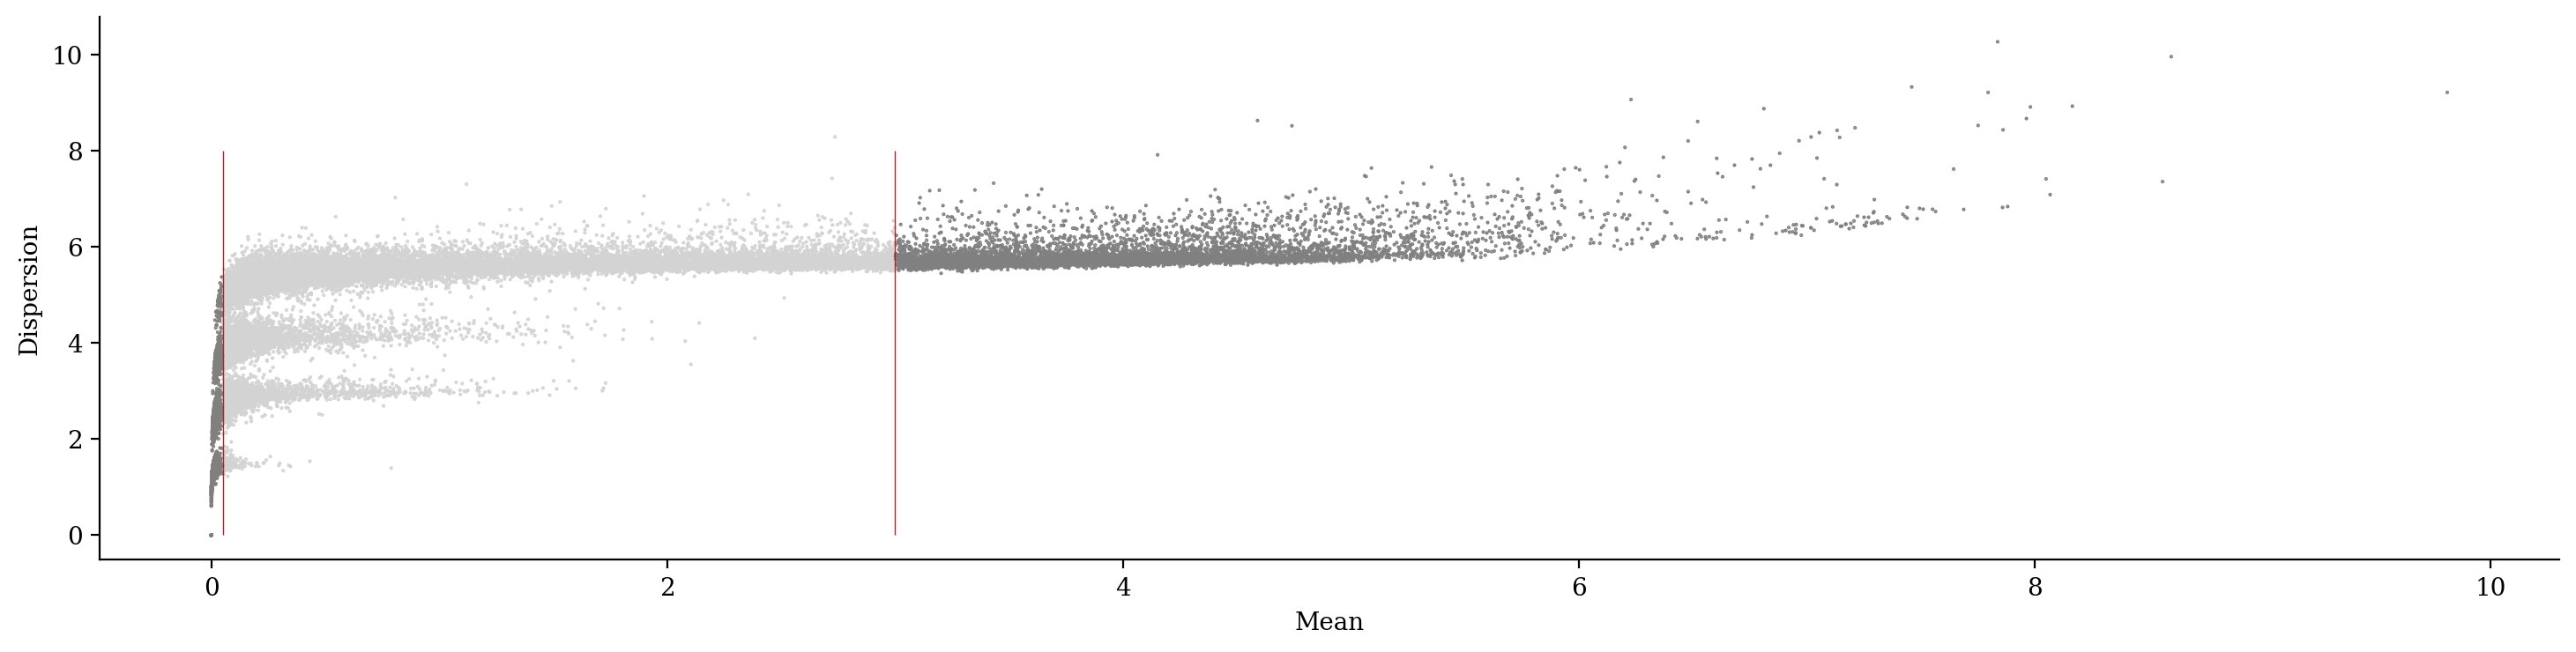

In [147]:
# Visualize the effect of thresholds.
filter_in = np.logical_and.reduce(
    (
        adata_dataset_1_var_before["means"] > (hvg_dict["min_mean"] if hvg_dict["min_mean"] is not None else -np.inf),
        adata_dataset_1_var_before["means"] < (hvg_dict["max_mean"] if hvg_dict["max_mean"] is not None else np.inf),
    )
)
print(f"Filter-in:  {np.sum(filter_in)}")
print(f"Filter-out: {len(adata_dataset_1_var_before) - np.sum(filter_in)}")

boolean_to_color = {True: "lightgray", False: "gray"}
hvg_colors = pd.Series(filter_in).map(boolean_to_color)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [148]:
_, final_hvg_selection, _ = select_hvgs(
    adata_var=adata_dataset_1.var.copy(),
    top_gene_number=hvg_dict["hvg_number"],
    min_mean=hvg_dict["min_mean"],
    max_mean=hvg_dict["max_mean"],
)

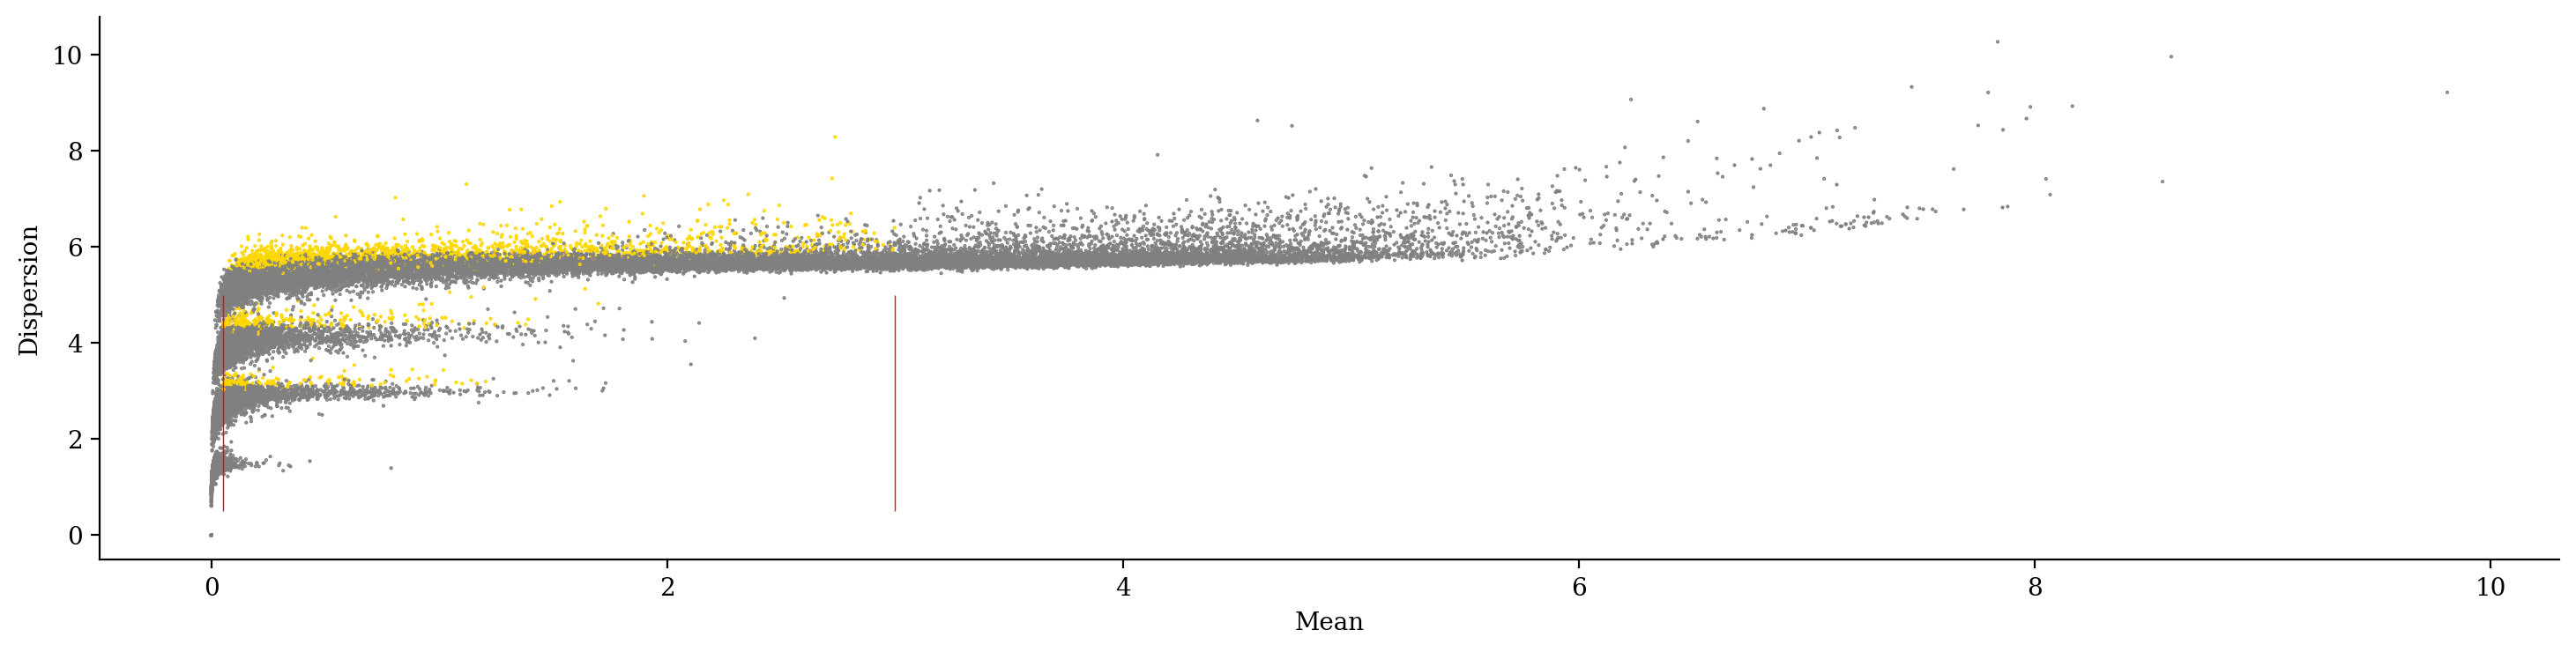

In [149]:
boolean_to_color = {True: "gold", False: "gray"}
chosen_highly_variables = adata_dataset_1_var_before.index.isin(final_hvg_selection)
hvg_colors = pd.Series(chosen_highly_variables).map(boolean_to_color)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [150]:
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var.index.isin(final_hvg_selection)]
adata_dataset_1.shape

(24634, 2048)

In [151]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

adata_dataset_1.X = adata_dataset_1.layers["counts"].copy()
del adata_dataset_1.layers
del adata_dataset_1.uns
del adata_dataset_1.var
adata_dataset_1.obs = adata_dataset_1.obs[
    [
        "sample_ID",
        "organ",
        "age",
        "cell_type",
        "sex",
        "sex_inferred",
        "concatenated_integration_covariates",
        "integration_donor",
        "integration_biological_unit",
        "integration_sample_status",
        "integration_library_platform_coarse",
    ]
]
gc.collect()

print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

print()
display(adata_dataset_1)

Estimated adata memory usage: 20.44 MB
Estimated adata memory usage: 11.29 MB



AnnData object with n_obs × n_vars = 24634 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'

In [152]:
write_path = "/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/" "dataset_subset_biological_unit_1.h5ad"
adata_dataset_1.write_h5ad(write_path)

In [153]:
sc.pp.filter_cells(adata_dataset_1, min_genes=10, inplace=True)
display(adata_dataset_1.obs["integration_biological_unit"].value_counts())
print()

sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)
print()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", ".*DataFrame is highly fragmented.*")
    calculate_de_genes(adata_dataset_1)
calc_de = copy.deepcopy(adata_dataset_1.uns[RANK_GENES_GROUPS_KEY])
display(adata_dataset_1)
print()
del adata_dataset_1
gc.collect();

adata_dataset_1 = ad.read_h5ad(write_path)
adata_dataset_1.uns[RANK_GENES_GROUPS_KEY] = calc_de
display(adata_dataset_1)
print()
adata_dataset_1.write_h5ad(write_path)
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")
del adata_dataset_1
gc.collect();

filtered out 2675 cells that have less than 10 genes expressed


Nuclei    12924
Cell       9035
Name: integration_biological_unit, dtype: int64


normalizing counts per cell
    finished (0:00:00)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


AnnData object with n_obs × n_vars = 21959 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes'
    uns: 'log1p', 'rank_genes_groups'

AnnData object with n_obs × n_vars = 24634 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'
    uns: 'rank_genes_groups'


Estimated adata memory usage: 11.86 MB


## Training data for `sample_status` experiment

In [154]:
stats_garcia = batch_stats[batch_stats["dataset"] == "Garcia"].copy()
for i in ['sex', 'organ', 'age', 'library_platform', 'biological_unit', 'sample_status']:
    assert all([len(j) == 1 for j in stats_garcia[i]])
    stats_garcia[i] = [j[0] for j in stats_garcia[i]]
stats_garcia = stats_garcia[stats_garcia["n_cells"] > 1000]

In [155]:
garcia_chosen_batches = [
    # MALE:
    "Hrv25_Garcia_et_al_Cell_Frozen_5GEX", 
    "Hrv27_Garcia_et_al_Cell_Fresh_5GEX",
    
    # FEMALE:
    # "Hrv39_Garcia_et_al_Cell_Frozen_5GEX",
    # "F96_Garcia_et_al_Cell_Fresh_5GEX",
    
    # Ignored due to male and female difference:
    # "Hrv41_Garcia_et_al_Cell_Frozen_5GEX", 
    # "F81_Garcia_et_al_Cell_Fresh_5GEX"
]
stats_garcia_chosen = stats_garcia[stats_garcia["batch_key"].isin(garcia_chosen_batches)].copy()
stats_garcia_chosen

dataset                            batch_key sex  organ   age  \
75  Garcia  Hrv25_Garcia_et_al_Cell_Frozen_5GEX   M  Gonad  14.0   
78  Garcia   Hrv27_Garcia_et_al_Cell_Fresh_5GEX   M  Gonad  14.0   

   library_platform biological_unit sample_status  n_library_platform  \
75             5GEX            Cell        Frozen                   1   
78             5GEX            Cell         Fresh                   1   

    n_biological_unit  ...  n_organ  n_age  n_celltypes  n_cells  n_genes  \
75                  1  ...        1      1           19     6376    27687   
78                  1  ...        1      1           14     5162    27687   

    cells_per_celltypes         sum         mean           std  median  
75           335.578947  33533436.0  1211.161773  10613.948516    38.0  
78           368.714286  32170070.0  1161.919673  10288.012470    37.0  

[2 rows x 22 columns]

In [156]:
stats_garcia_chosen.groupby('sample_status').agg(Size=('sample_status', 'size'), Sum=('n_cells', 'sum'))

Size   Sum
sample_status            
Fresh             1  5162
Frozen            1  6376

In [157]:
adata_dataset_1 = adata[adata.obs["concatenated_integration_covariates"].isin(garcia_chosen_batches)]
batch_dataset = adata_dataset_1.obs["handle_anndata"].unique()[0]
var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var[var_column] != NA_CELL_TYPE_PLACEHOLDER].copy()
adata_dataset_1.shape

(11538, 27687)

In [158]:
min_cell_count = 90
batches_cell_type = list()
for batch_key in garcia_chosen_batches:
    batch_adata_obs = adata_dataset_1.obs[adata_dataset_1.obs["concatenated_integration_covariates"] == batch_key]
    batch_cell_type_vc = batch_adata_obs["cell_type"].value_counts()
    batch_cell_type = set(batch_cell_type_vc[batch_cell_type_vc > min_cell_count].index)
    batches_cell_type.append(batch_cell_type)
chosen_cell_types = reduce(set.intersection, batches_cell_type)
adata_dataset_1 = adata_dataset_1[adata_dataset_1.obs["cell_type"].isin(chosen_cell_types), :].copy()
adata_dataset_1.shape, len(chosen_cell_types)

((11279, 27687), 4)

In [159]:
adata_dataset_1.obs.groupby("sample_status").size()

sample_status
Fresh     5060
Frozen    6219
dtype: int64

In [160]:
# remove cell-cycle, bcr, tcr. Also, scanpy filter genes
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var["highly_variable_omitted_reason"] == "NA"].copy()
del adata_dataset_1.var
gc.collect()
adata_dataset_1.shape

(11279, 26911)

In [161]:
adata_dataset_1.layers["counts"] = adata_dataset_1.X.copy()
sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)

normalizing counts per cell
    finished (0:00:00)


In [162]:
# Calculate dispersion and mean with scanpy function to determine max and min means.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    highly_variable_genes(
        adata=adata_dataset_1, 
        layer=None, 
        batch_key="concatenated_integration_covariates", 
        subset=False, 
        inplace=True
    )
    adata_dataset_1.var.drop(columns=["highly_variable"], inplace=True)
adata_dataset_1_var_before = adata_dataset_1.var.copy()
gc.collect();

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [163]:
hvg_dict = dict(
    hvg_number=2**11, 
    min_mean=0.05, 
    max_mean=3
)

Filter-in:  12313
Filter-out: 14598


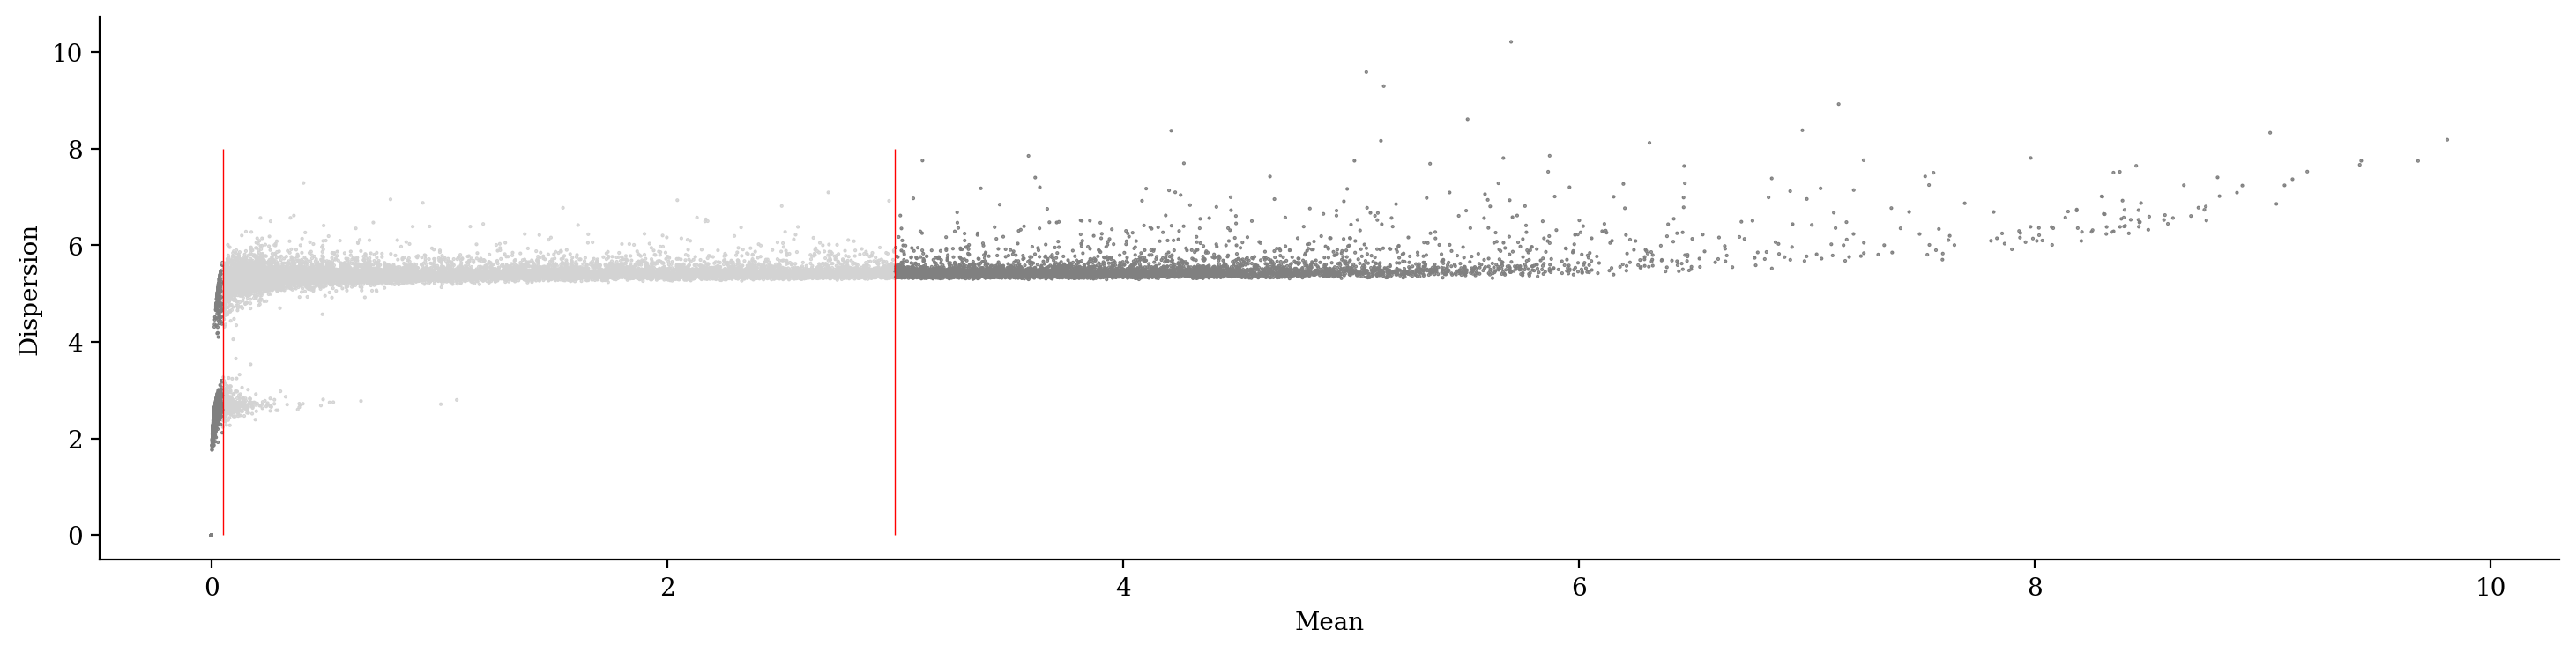

In [164]:
# Visualize the effect of thresholds.
filter_in = np.logical_and.reduce(
    (adata_dataset_1_var_before["means"] > (hvg_dict["min_mean"] if hvg_dict["min_mean"] is not None else -np.inf), 
     adata_dataset_1_var_before["means"] < (hvg_dict["max_mean"] if hvg_dict["max_mean"] is not None else np.inf)
    )
)
print(f"Filter-in:  {np.sum(filter_in)}")
print(f"Filter-out: {len(adata_dataset_1_var_before) - np.sum(filter_in)}")

boolean_to_color = {True: "lightgray", False: "gray"}
hvg_colors = pd.Series(filter_in).map(boolean_to_color)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [165]:
_, final_hvg_selection, _ = select_hvgs(
    adata_var=adata_dataset_1.var.copy(),
    top_gene_number=hvg_dict["hvg_number"],
    min_mean=hvg_dict["min_mean"],
    max_mean=hvg_dict["max_mean"],
)

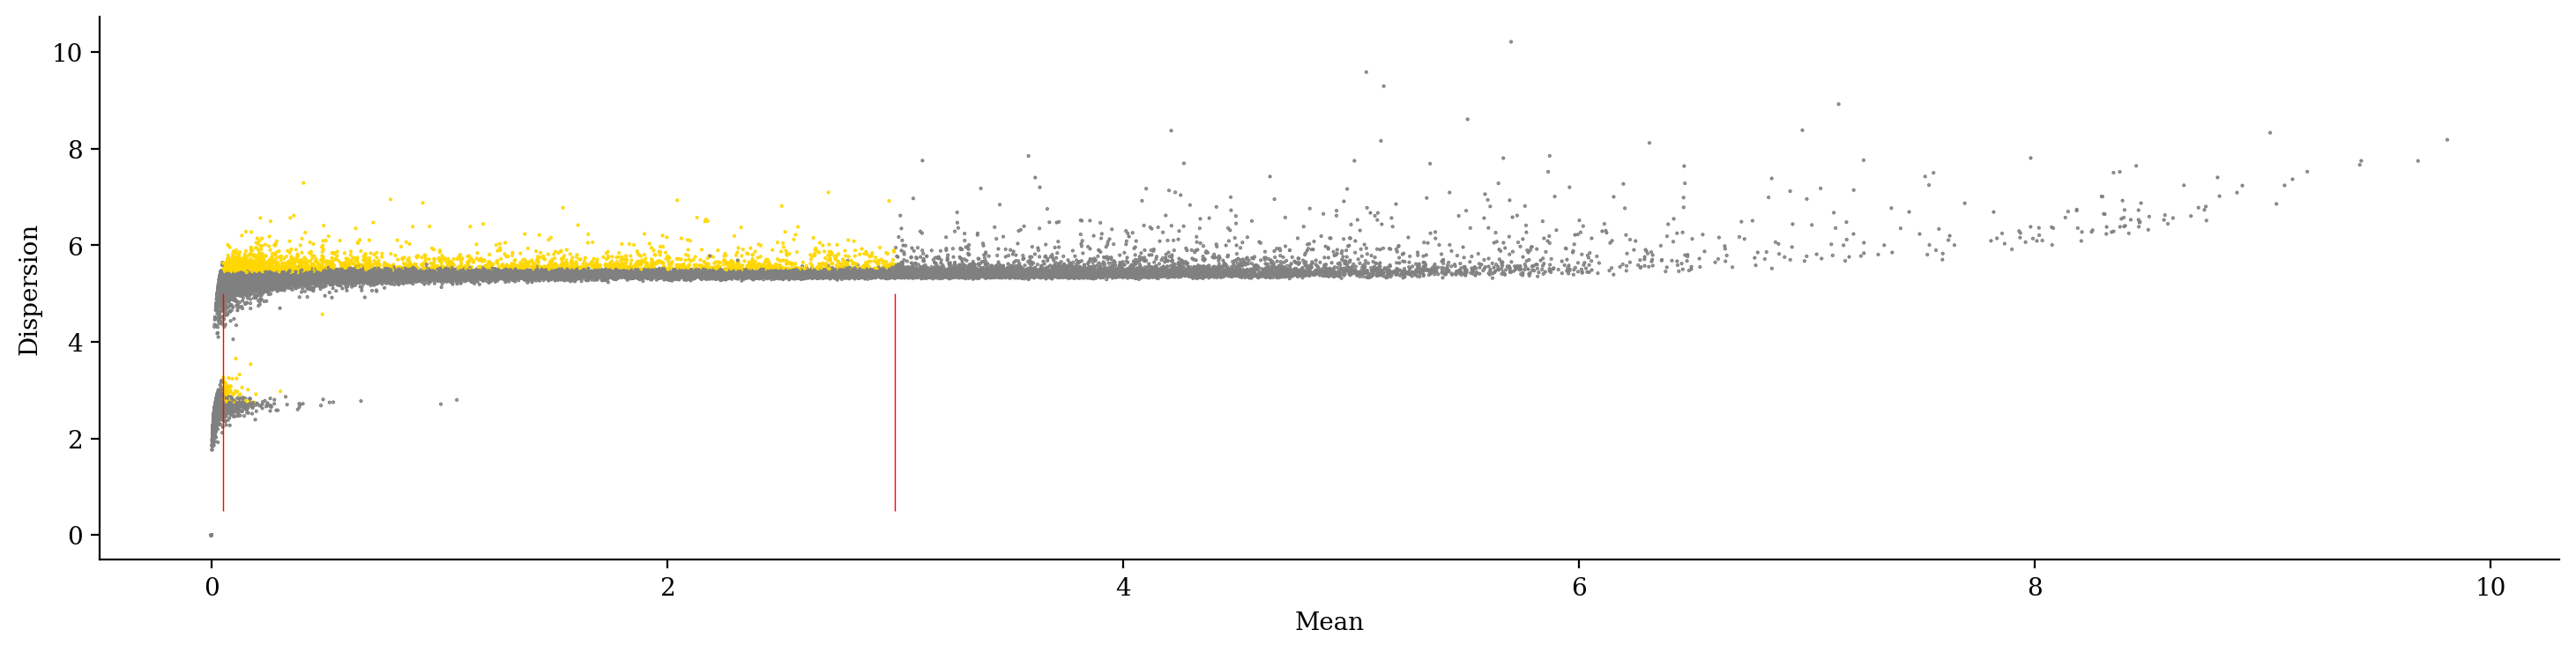

In [166]:
boolean_to_color = {True: "gold", False: "gray"}
chosen_highly_variables = adata_dataset_1_var_before.index.isin(final_hvg_selection)
hvg_colors = pd.Series(chosen_highly_variables).map(
    boolean_to_color
)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [167]:
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var.index.isin(final_hvg_selection)]
adata_dataset_1.shape

(11279, 2048)

In [168]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

adata_dataset_1.X = adata_dataset_1.layers["counts"].copy()
del adata_dataset_1.layers
del adata_dataset_1.uns
del adata_dataset_1.var
adata_dataset_1.obs = adata_dataset_1.obs[['sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates',
                       'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse']]
gc.collect()

print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

print()
display(adata_dataset_1)

Estimated adata memory usage: 11.42 MB
Estimated adata memory usage: 6.12 MB



AnnData object with n_obs × n_vars = 11279 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'

In [169]:
write_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/"
    "dataset_subset_sample_status_1.h5ad"
)
adata_dataset_1.write_h5ad(write_path)

In [170]:
sc.pp.filter_cells(adata_dataset_1, min_genes=10, inplace=True)
display(adata_dataset_1.obs["integration_biological_unit"].value_counts())
print()

sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)
print()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", ".*DataFrame is highly fragmented.*")
    calculate_de_genes(adata_dataset_1)
calc_de = copy.deepcopy(adata_dataset_1.uns[RANK_GENES_GROUPS_KEY])
display(adata_dataset_1)
print()
del adata_dataset_1
gc.collect();

adata_dataset_1 = ad.read_h5ad(write_path)
adata_dataset_1.uns[RANK_GENES_GROUPS_KEY] = calc_de
display(adata_dataset_1)
print()
adata_dataset_1.write_h5ad(write_path)
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")
del adata_dataset_1
gc.collect();

filtered out 875 cells that have less than 10 genes expressed


Cell    10404
Name: integration_biological_unit, dtype: int64


normalizing counts per cell
    finished (0:00:00)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


AnnData object with n_obs × n_vars = 10404 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes'
    uns: 'log1p', 'rank_genes_groups'

AnnData object with n_obs × n_vars = 11279 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'
    uns: 'rank_genes_groups'


Estimated adata memory usage: 6.44 MB


## Training data for `sex_1` experiment

In [171]:
stats_colin = batch_stats[batch_stats["dataset"] == "Colin"].copy()
for i in ['sex', 'organ', 'age', 'library_platform', 'biological_unit', 'sample_status']:
    assert all([len(j) == 1 for j in stats_colin[i]])
    stats_colin[i] = [j[0] for j in stats_colin[i]]

In [172]:
colin_chosen_batches = [
    "donor_1_PCW13_Colin_et_al_Cell_Frozen_3GEX", 
    "donor_3_PCW13_Colin_et_al_Cell_Frozen_3GEX", 
    "donor_2_PCW13_Colin_et_al_Cell_Frozen_3GEX", 
    "donor_4_PCW13_Colin_et_al_Cell_Frozen_3GEX",
]
stats_colin_chosen = stats_colin[stats_colin["batch_key"].isin(colin_chosen_batches)].copy()
stats_colin_chosen

dataset                                   batch_key sex   organ   age  \
35   Colin  donor_1_PCW13_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  13.0   
36   Colin  donor_2_PCW13_Colin_et_al_Cell_Frozen_3GEX   M  Cornea  13.0   
37   Colin  donor_3_PCW13_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  13.0   
38   Colin  donor_4_PCW13_Colin_et_al_Cell_Frozen_3GEX   M  Cornea  13.0   

   library_platform biological_unit sample_status  n_library_platform  \
35             3GEX            Cell        Frozen                   1   
36             3GEX            Cell        Frozen                   1   
37             3GEX            Cell        Frozen                   1   
38             3GEX            Cell        Frozen                   1   

    n_biological_unit  ...  n_organ  n_age  n_celltypes  n_cells  n_genes  \
35                  1  ...        1      1           14     7289    20820   
36                  1  ...        1      1           14     2804    20820   
37                  1  ...        1      1           14     5303    20820   
38                  1  ...        1      1           14     5525    20820   

    cells_per_celltypes         sum         mean           std  median  
35           520.642857  60013121.0  2882.474592  26205.979552   296.0  
36           200.285714  16949547.0   814.099280   8496.621575    91.0  
37           378.785714  47593950.0  2285.972622  25300.055451   246.0  
38           394.642857  79464637.0  3816.745293  33878.817705   471.5  

[4 rows x 22 columns]

In [173]:
stats_colin_chosen.groupby('sex').agg(Size=('sex', 'size'), Sum=('n_cells', 'sum'))

Size    Sum
sex             
F       2  12592
M       2   8329

In [174]:
adata_dataset_1 = adata[adata.obs["concatenated_integration_covariates"].isin(colin_chosen_batches)]
batch_dataset = adata_dataset_1.obs["handle_anndata"].unique()[0]
var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var[var_column] != NA_CELL_TYPE_PLACEHOLDER].copy()
adata_dataset_1.shape

(20921, 20820)

In [175]:
min_cell_count = 180
batches_cell_type = list()
for batch_key in colin_chosen_batches:
    batch_adata_obs = adata_dataset_1.obs[adata_dataset_1.obs["concatenated_integration_covariates"] == batch_key]
    batch_cell_type_vc = batch_adata_obs["cell_type"].value_counts()
    batch_cell_type = set(batch_cell_type_vc[batch_cell_type_vc > min_cell_count].index)
    batches_cell_type.append(batch_cell_type)
chosen_cell_types = reduce(set.intersection, batches_cell_type)
adata_dataset_1 = adata_dataset_1[adata_dataset_1.obs["cell_type"].isin(chosen_cell_types), :].copy()
adata_dataset_1.shape, len(chosen_cell_types)

((13264, 20820), 4)

In [176]:
adata_dataset_1.obs.groupby(["sex"]).size()

sex
F    8178
M    5086
dtype: int64

In [177]:
# remove cell-cycle, bcr, tcr. Also, scanpy filter genes
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var["highly_variable_omitted_reason"] == "NA"].copy()
del adata_dataset_1.var
gc.collect()
adata_dataset_1.shape

(13264, 20296)

In [178]:
adata_dataset_1.layers["counts"] = adata_dataset_1.X.copy()
sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)

normalizing counts per cell
    finished (0:00:00)


In [179]:
# Calculate dispersion and mean with scanpy function to determine max and min means.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    highly_variable_genes(
        adata=adata_dataset_1, 
        layer=None, 
        batch_key="concatenated_integration_covariates", 
        subset=False, 
        inplace=True
    )
    adata_dataset_1.var.drop(columns=["highly_variable"], inplace=True)
adata_dataset_1_var_before = adata_dataset_1.var.copy()
gc.collect();

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [180]:
hvg_dict = dict(
    hvg_number=2**11, 
    min_mean=0.05, 
    max_mean=3
)

Filter-in:  11617
Filter-out: 8679


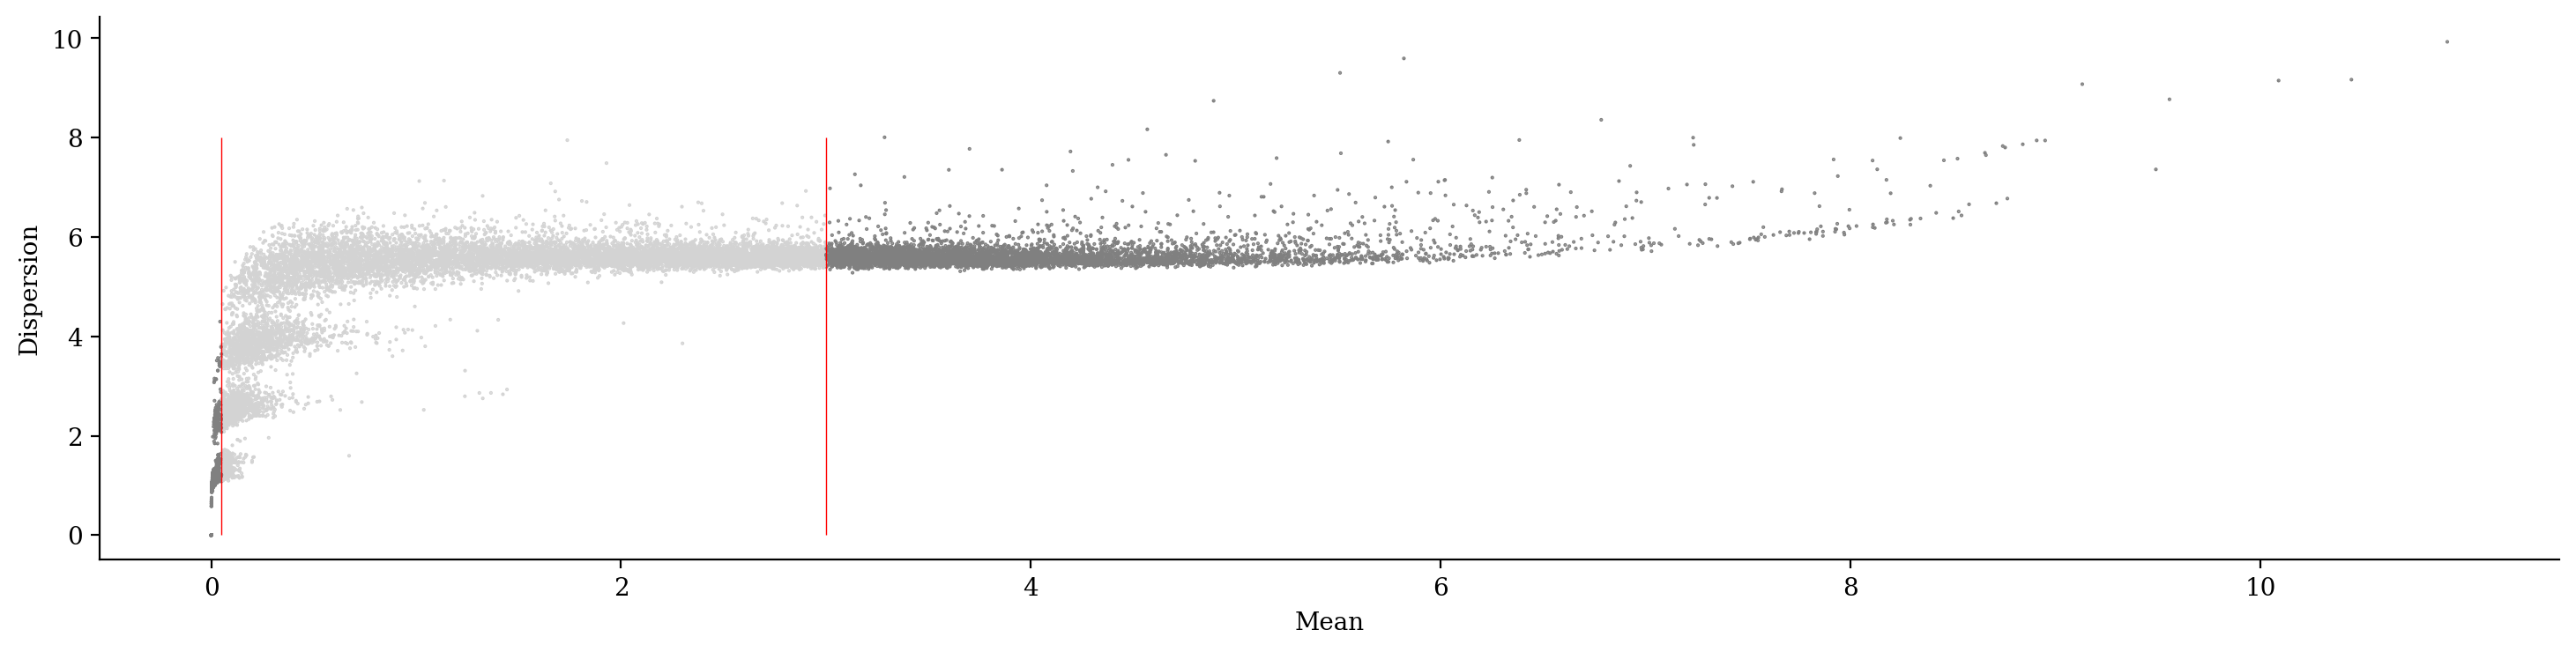

In [181]:
# Visualize the effect of thresholds.
filter_in = np.logical_and.reduce(
    (adata_dataset_1_var_before["means"] > (hvg_dict["min_mean"] if hvg_dict["min_mean"] is not None else -np.inf), 
     adata_dataset_1_var_before["means"] < (hvg_dict["max_mean"] if hvg_dict["max_mean"] is not None else np.inf)
    )
)
print(f"Filter-in:  {np.sum(filter_in)}")
print(f"Filter-out: {len(adata_dataset_1_var_before) - np.sum(filter_in)}")

boolean_to_color = {True: "lightgray", False: "gray"}
hvg_colors = pd.Series(filter_in).map(boolean_to_color)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [182]:
_, final_hvg_selection, _ = select_hvgs(
    adata_var=adata_dataset_1.var.copy(),
    top_gene_number=hvg_dict["hvg_number"],
    min_mean=hvg_dict["min_mean"],
    max_mean=hvg_dict["max_mean"],
)

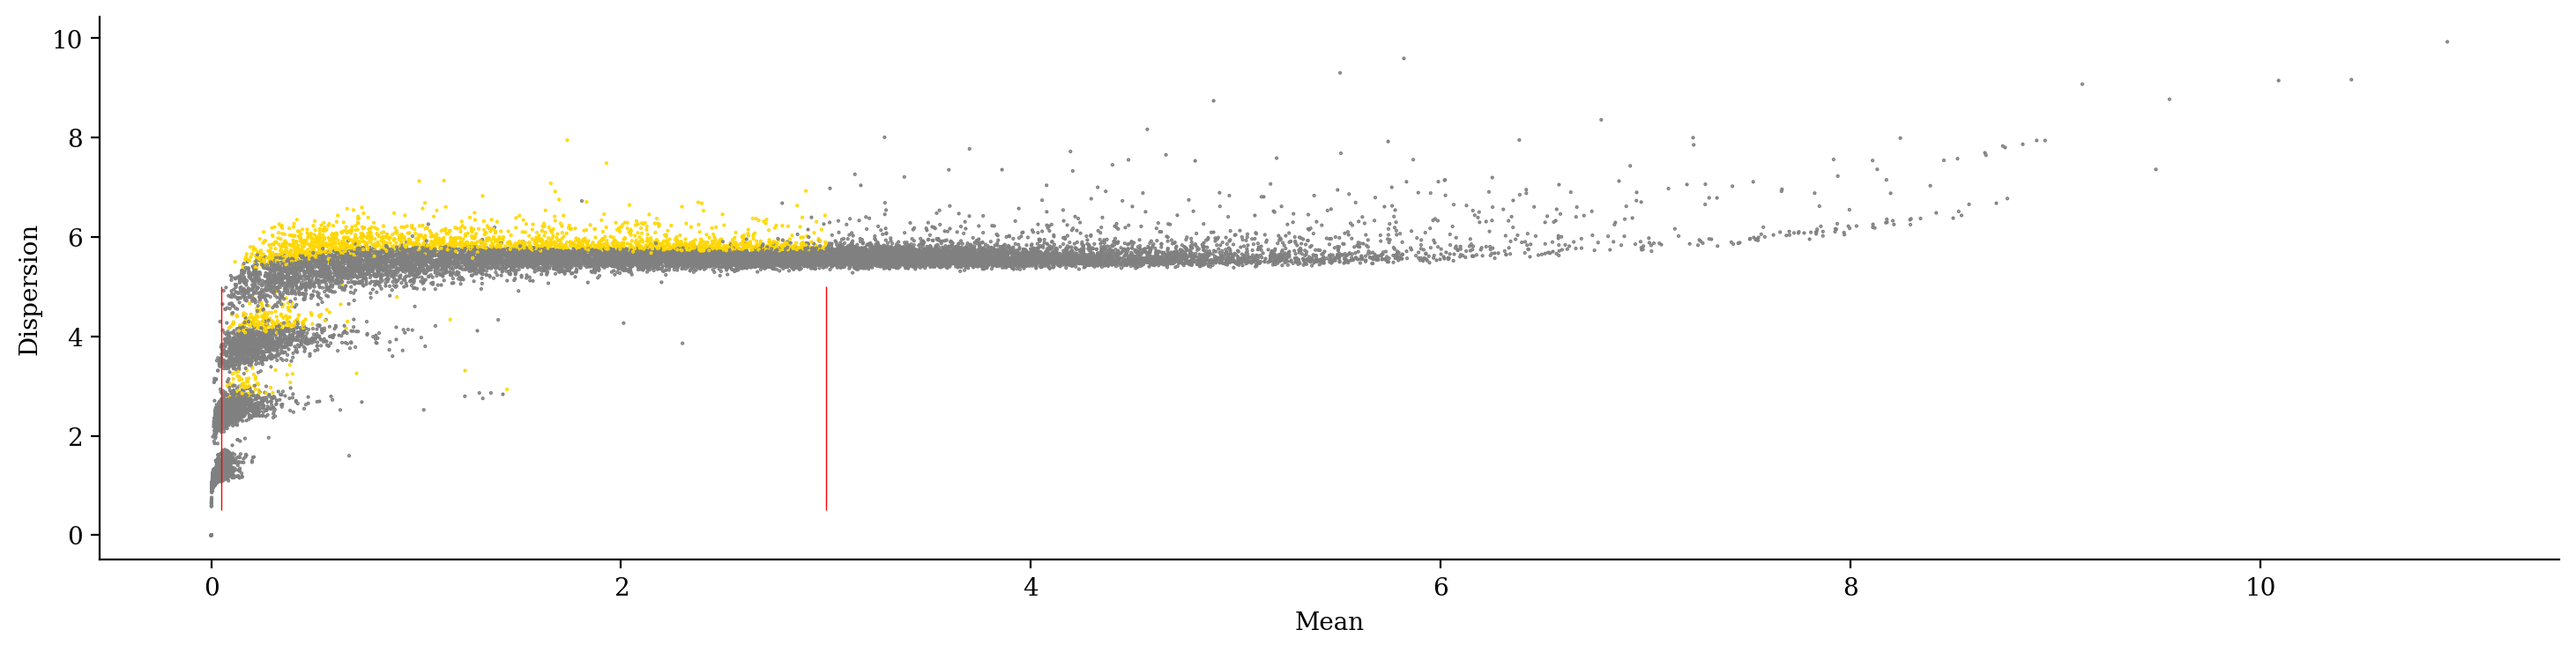

In [183]:
boolean_to_color = {True: "gold", False: "gray"}
chosen_highly_variables = adata_dataset_1_var_before.index.isin(final_hvg_selection)
hvg_colors = pd.Series(chosen_highly_variables).map(
    boolean_to_color
)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [184]:
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var.index.isin(final_hvg_selection)]
adata_dataset_1.shape

(13264, 2048)

In [185]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

adata_dataset_1.X = adata_dataset_1.layers["counts"].copy()
del adata_dataset_1.layers
del adata_dataset_1.uns
del adata_dataset_1.var
adata_dataset_1.obs = adata_dataset_1.obs[['sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates',
                       'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse']]
gc.collect()

print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

print()
display(adata_dataset_1)

Estimated adata memory usage: 19.2 MB
Estimated adata memory usage: 9.93 MB



AnnData object with n_obs × n_vars = 13264 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'

In [186]:
write_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/"
    "dataset_subset_sex_1.h5ad"
)
adata_dataset_1.write_h5ad(write_path)

In [187]:
sc.pp.filter_cells(adata_dataset_1, min_genes=10, inplace=True)
display(adata_dataset_1.obs["sex"].value_counts())
print()

sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)
print()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", ".*DataFrame is highly fragmented.*")
    calculate_de_genes(adata_dataset_1)
calc_de = copy.deepcopy(adata_dataset_1.uns[RANK_GENES_GROUPS_KEY])
display(adata_dataset_1)
print()
del adata_dataset_1
gc.collect();

adata_dataset_1 = ad.read_h5ad(write_path)
adata_dataset_1.uns[RANK_GENES_GROUPS_KEY] = calc_de
display(adata_dataset_1)
print()
adata_dataset_1.write_h5ad(write_path)
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")
del adata_dataset_1
gc.collect();

filtered out 214 cells that have less than 10 genes expressed


F    8039
M    5011
Name: sex, dtype: int64


normalizing counts per cell
    finished (0:00:00)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


AnnData object with n_obs × n_vars = 13050 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes'
    uns: 'log1p', 'rank_genes_groups'

AnnData object with n_obs × n_vars = 13264 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'
    uns: 'rank_genes_groups'


Estimated adata memory usage: 10.49 MB


## Training data for `sex_2` experiment

In [188]:
stats_he = batch_stats[batch_stats["dataset"] == "Braun"].copy()
for i in ['sex', 'organ', 'age', 'library_platform', 'biological_unit', 'sample_status']:
    assert all([len(j) == 1 for j in stats_he[i]])
    stats_he[i] = [j[0] for j in stats_he[i]]

In [189]:
stats_he = stats_he.sort_values(by=["age", "sex", "n_cells"], ascending=False)
stats_he = stats_he[stats_he["age"].isin([6.9])].drop_duplicates(["age", "sex"])
he_chosen_batches = list(stats_he["batch_key"].unique())
stats_he_chosen = stats_he[stats_he["batch_key"].isin(he_chosen_batches)].copy()
stats_he_chosen

dataset                            batch_key sex  organ  age  \
19   Braun  BRC2191_Braun_et_al_Cell_Fresh_3GEX   M  Brain  6.9   
16   Braun  BRC2061_Braun_et_al_Cell_Fresh_3GEX   F  Brain  6.9   

   library_platform biological_unit sample_status  n_library_platform  \
19             3GEX            Cell         Fresh                   1   
16             3GEX            Cell         Fresh                   1   

    n_biological_unit  ...  n_organ  n_age  n_celltypes  n_cells  n_genes  \
19                  1  ...        1      1           48   158702    55612   
16                  1  ...        1      1           45   128307    55612   

    cells_per_celltypes           sum          mean            std  median  
19          3306.291667  1.075049e+09  19331.241063  288936.069275    72.0  
16          2851.266667  1.153373e+09  20739.636715  224783.385734    63.0  

[2 rows x 22 columns]

In [190]:
stats_he_chosen.groupby('sex').agg(Size=('sex', 'size'), Sum=('n_cells', 'sum'))

Size     Sum
sex              
F       1  128307
M       1  158702

In [191]:
adata_dataset_1 = adata[adata.obs["concatenated_integration_covariates"].isin(he_chosen_batches)]
batch_dataset = adata_dataset_1.obs["handle_anndata"].unique()[0]
var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var[var_column] != NA_CELL_TYPE_PLACEHOLDER].copy()
adata_dataset_1.shape

(287009, 55612)

In [192]:
min_cell_count = 2000
batches_cell_type = list()
for batch_key in he_chosen_batches:
    batch_adata_obs = adata_dataset_1.obs[adata_dataset_1.obs["concatenated_integration_covariates"] == batch_key]
    batch_cell_type_vc = batch_adata_obs["cell_type"].value_counts()
    batch_cell_type = set(batch_cell_type_vc[batch_cell_type_vc > min_cell_count].index)
    batches_cell_type.append(batch_cell_type)
chosen_cell_types = reduce(set.intersection, batches_cell_type)
adata_dataset_1 = adata_dataset_1[adata_dataset_1.obs["cell_type"].isin(chosen_cell_types), :].copy()
adata_dataset_1.shape, len(chosen_cell_types)

((158503, 55612), 9)

In [193]:
sc.pp.subsample(adata_dataset_1, fraction=0.10, random_state=0)
adata_dataset_1.shape

(15850, 55612)

In [194]:
adata_dataset_1.obs.groupby("sex").size()

sex
F    7745
M    8105
dtype: int64

In [195]:
# remove cell-cycle, bcr, tcr. Also, scanpy filter genes
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var["highly_variable_omitted_reason"] == "NA"].copy()
del adata_dataset_1.var
gc.collect()
adata_dataset_1.shape

(15850, 43352)

In [196]:
adata_dataset_1.layers["counts"] = adata_dataset_1.X.copy()
sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)

normalizing counts per cell
    finished (0:00:00)


In [197]:
# Calculate dispersion and mean with scanpy function to determine max and min means.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    highly_variable_genes(
        adata=adata_dataset_1, 
        layer=None, 
        batch_key="concatenated_integration_covariates", 
        subset=False, 
        inplace=True
    )
    adata_dataset_1.var.drop(columns=["highly_variable"], inplace=True)
adata_dataset_1_var_before = adata_dataset_1.var.copy()
gc.collect();

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [198]:
hvg_dict = dict(
    hvg_number=2**11, 
    min_mean=0.05, 
    max_mean=3
)

Filter-in:  20119
Filter-out: 23233


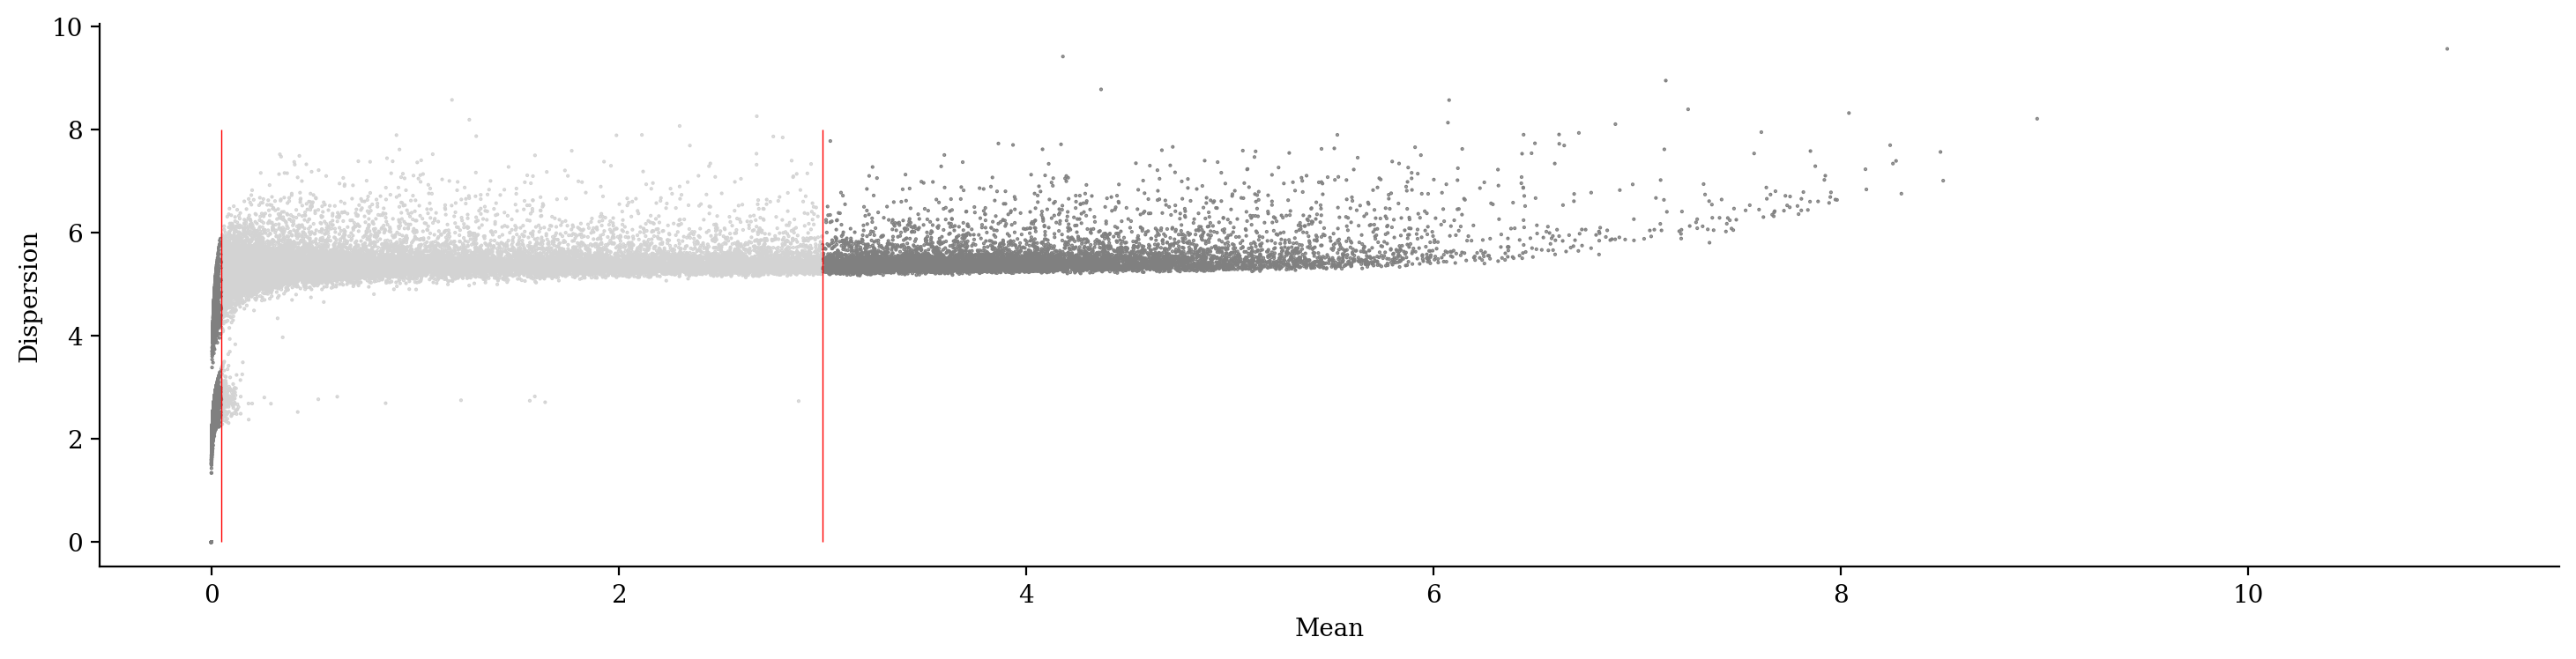

In [199]:
# Visualize the effect of thresholds.
filter_in = np.logical_and.reduce(
    (adata_dataset_1_var_before["means"] > (hvg_dict["min_mean"] if hvg_dict["min_mean"] is not None else -np.inf), 
     adata_dataset_1_var_before["means"] < (hvg_dict["max_mean"] if hvg_dict["max_mean"] is not None else np.inf)
    )
)
print(f"Filter-in:  {np.sum(filter_in)}")
print(f"Filter-out: {len(adata_dataset_1_var_before) - np.sum(filter_in)}")

boolean_to_color = {True: "lightgray", False: "gray"}
hvg_colors = pd.Series(filter_in).map(boolean_to_color)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [200]:
_, final_hvg_selection, _ = select_hvgs(
    adata_var=adata_dataset_1.var.copy(),
    top_gene_number=hvg_dict["hvg_number"],
    min_mean=hvg_dict["min_mean"],
    max_mean=hvg_dict["max_mean"],
)

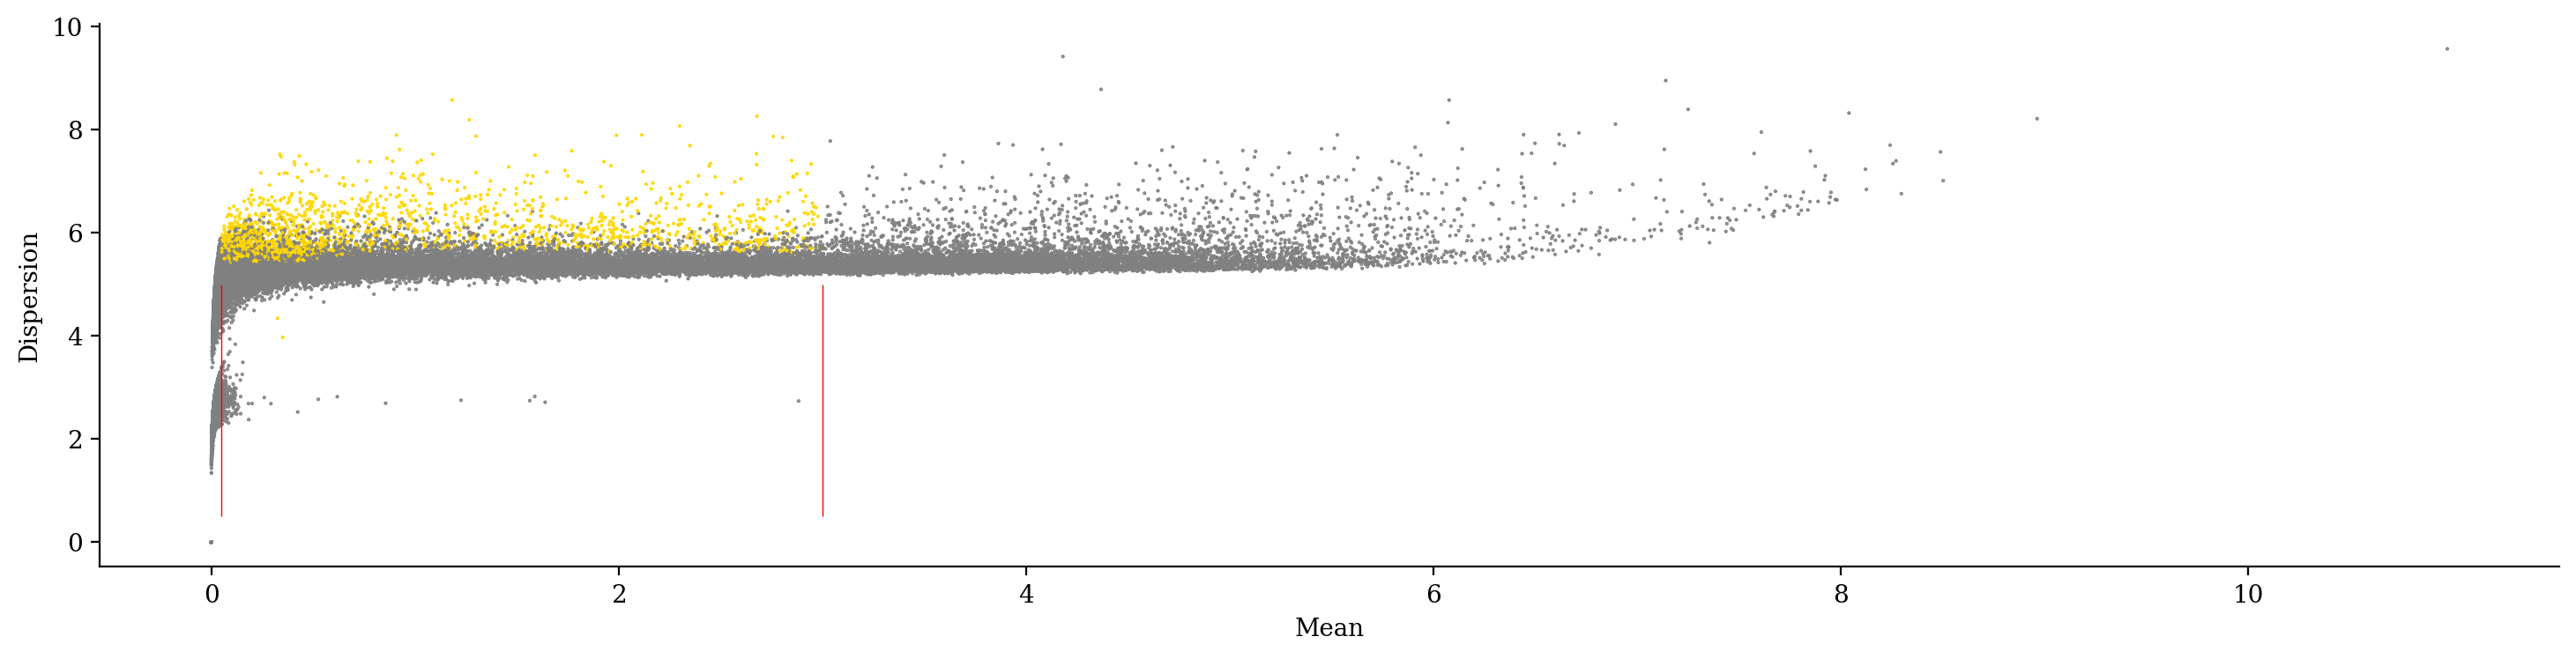

In [201]:
boolean_to_color = {True: "gold", False: "gray"}
chosen_highly_variables = adata_dataset_1_var_before.index.isin(final_hvg_selection)
hvg_colors = pd.Series(chosen_highly_variables).map(
    boolean_to_color
)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [202]:
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var.index.isin(final_hvg_selection)]
adata_dataset_1.shape

(15850, 2048)

In [203]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

adata_dataset_1.X = adata_dataset_1.layers["counts"].copy()
del adata_dataset_1.layers
del adata_dataset_1.uns
del adata_dataset_1.var
adata_dataset_1.obs = adata_dataset_1.obs[['sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates',
                       'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse']]
gc.collect()

print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

print()
display(adata_dataset_1)

Estimated adata memory usage: 11.52 MB
Estimated adata memory usage: 6.19 MB



AnnData object with n_obs × n_vars = 15850 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'

In [204]:
write_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/"
    "dataset_subset_sex_2.h5ad"
)
adata_dataset_1.write_h5ad(write_path)

In [205]:
sc.pp.filter_cells(adata_dataset_1, min_genes=10, inplace=True)
display(adata_dataset_1.obs["sex"].value_counts())
print()

sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)
print()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", ".*DataFrame is highly fragmented.*")
    calculate_de_genes(adata_dataset_1)
calc_de = copy.deepcopy(adata_dataset_1.uns[RANK_GENES_GROUPS_KEY])
display(adata_dataset_1)
print()
del adata_dataset_1
gc.collect();

adata_dataset_1 = ad.read_h5ad(write_path)
adata_dataset_1.uns[RANK_GENES_GROUPS_KEY] = calc_de
display(adata_dataset_1)
print()
adata_dataset_1.write_h5ad(write_path)
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")
del adata_dataset_1
gc.collect();

filtered out 2016 cells that have less than 10 genes expressed


F    7423
M    6411
Name: sex, dtype: int64


normalizing counts per cell
    finished (0:00:00)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


AnnData object with n_obs × n_vars = 13834 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes'
    uns: 'log1p', 'rank_genes_groups'

AnnData object with n_obs × n_vars = 15850 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'
    uns: 'rank_genes_groups'


Estimated adata memory usage: 6.76 MB


## Training data for `age_1` experiment

In [206]:
stats_he = batch_stats[batch_stats["dataset"] == "He"].copy()
for i in ['sex', 'organ', 'age', 'library_platform', 'biological_unit', 'sample_status']:
    assert all([len(j) == 1 for j in stats_he[i]])
    stats_he[i] = [j[0] for j in stats_he[i]]
stats_he = stats_he.sort_values(by=["sex", "age", "n_cells"], ascending=False).drop_duplicates(["age"])
stats_he = stats_he[stats_he["sex"] == "M"]
he_chosen_batches = list(stats_he["batch_key"])

In [207]:
stats_he_chosen = stats_he[stats_he["batch_key"].isin(he_chosen_batches)].copy()
stats_he_chosen

dataset                           batch_key sex organ   age  \
109      He  HDBR15168_He_et_al_Cell_Fresh_5GEX   M  Lung  22.0   
108      He  HDBR15167_He_et_al_Cell_Fresh_5GEX   M  Lung  20.0   
111      He  HDBR15219_He_et_al_Cell_Fresh_5GEX   M  Lung  18.0   
110      He  HDBR15233_He_et_al_Cell_Fresh_5GEX   M  Lung  15.0   
113      He  HDBR15280_He_et_al_Cell_Fresh_5GEX   M  Lung  11.0   

    library_platform biological_unit sample_status  n_library_platform  \
109             5GEX            Cell         Fresh                   1   
108             5GEX            Cell         Fresh                   1   
111             5GEX            Cell         Fresh                   1   
110             5GEX            Cell         Fresh                   1   
113             5GEX            Cell         Fresh                   1   

     n_biological_unit  ...  n_organ  n_age  n_celltypes  n_cells  n_genes  \
109                  1  ...        1      1           96     9914    25373   
108                  1  ...        1      1           91     4807    25373   
111                  1  ...        1      1          101    11020    25373   
110                  1  ...        1      1          103     7489    25373   
113                  1  ...        1      1           84     9529    25373   

     cells_per_celltypes         sum         mean           std  median  
109           103.270833  67220351.0  2649.286683  26039.195942   295.0  
108            52.824176  34245790.0  1349.694163   9914.333576   152.0  
111           109.108911  79402944.0  3129.426713  21573.513640   357.0  
110            72.708738  66786208.0  2632.176250  19219.067058   276.0  
113           113.440476  88630722.0  3493.111654  25096.585044   299.0  

[5 rows x 22 columns]

In [208]:
stats_he_chosen.groupby('age').agg(Size=('age', 'size'), Sum=('n_cells', 'sum'))

Size    Sum
age              
11.0     1   9529
15.0     1   7489
18.0     1  11020
20.0     1   4807
22.0     1   9914

In [209]:
adata_dataset_1 = adata[adata.obs["concatenated_integration_covariates"].isin(he_chosen_batches)]
batch_dataset = adata_dataset_1.obs["handle_anndata"].unique()[0]
var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var[var_column] != NA_CELL_TYPE_PLACEHOLDER].copy()
adata_dataset_1.shape

(42759, 25373)

In [210]:
min_cell_count = 10
batches_cell_type = list()
for batch_key in he_chosen_batches:
    batch_adata_obs = adata_dataset_1.obs[adata_dataset_1.obs["concatenated_integration_covariates"] == batch_key]
    batch_cell_type_vc = batch_adata_obs["cell_type"].value_counts()
    batch_cell_type = set(batch_cell_type_vc[batch_cell_type_vc > min_cell_count].index)
    batches_cell_type.append(batch_cell_type)
chosen_cell_types = reduce(set.intersection, batches_cell_type)
adata_dataset_1 = adata_dataset_1[adata_dataset_1.obs["cell_type"].isin(chosen_cell_types), :].copy()
adata_dataset_1.shape, len(chosen_cell_types)

((21476, 25373), 11)

In [211]:
adata_dataset_1.obs.groupby("age").size()

age
11.0    6492
15.0    3488
18.0    4591
20.0    1676
22.0    5229
dtype: int64

In [212]:
# remove cell-cycle, bcr, tcr. Also, scanpy filter genes
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var["highly_variable_omitted_reason"] == "NA"].copy()
del adata_dataset_1.var
gc.collect()
adata_dataset_1.shape

(21476, 24563)

In [213]:
adata_dataset_1.layers["counts"] = adata_dataset_1.X.copy()
sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)

normalizing counts per cell
    finished (0:00:00)


In [214]:
# Calculate dispersion and mean with scanpy function to determine max and min means.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    highly_variable_genes(
        adata=adata_dataset_1, 
        layer=None, 
        batch_key="concatenated_integration_covariates", 
        subset=False, 
        inplace=True
    )
    adata_dataset_1.var.drop(columns=["highly_variable"], inplace=True)
adata_dataset_1_var_before = adata_dataset_1.var.copy()
gc.collect();

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [215]:
hvg_dict = dict(
    hvg_number=2**11, 
    min_mean=0.05, 
    max_mean=3
)

Filter-in:  12513
Filter-out: 12050


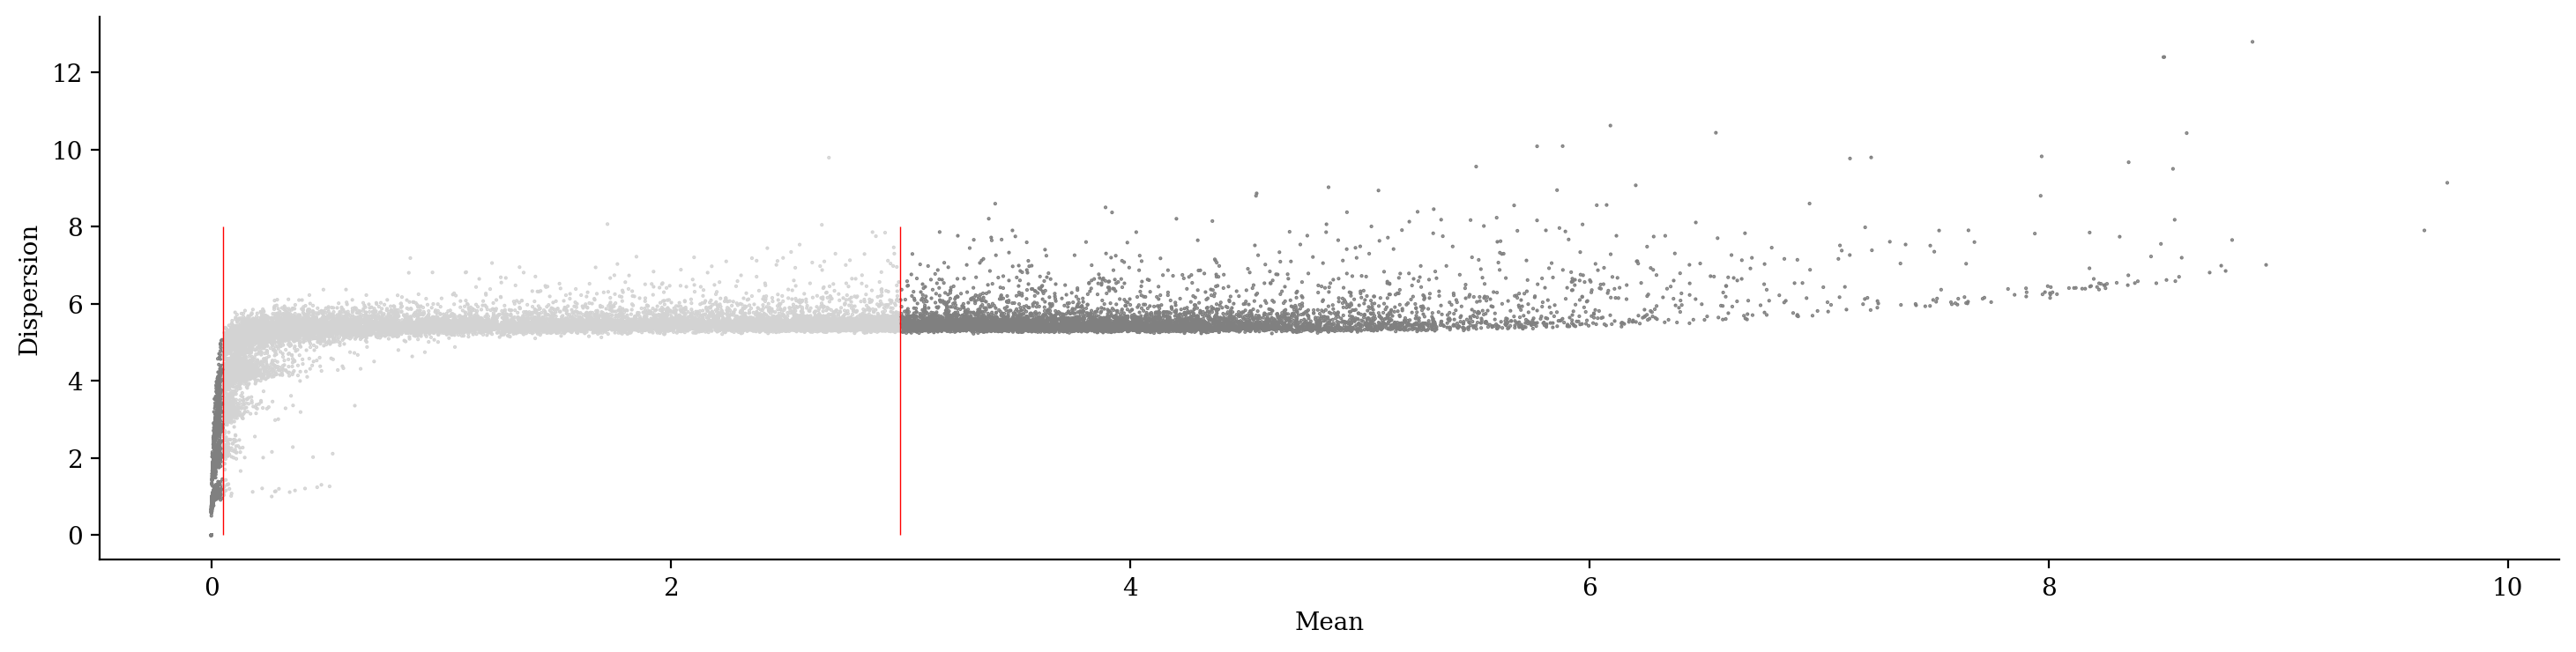

In [216]:
# Visualize the effect of thresholds.
filter_in = np.logical_and.reduce(
    (adata_dataset_1_var_before["means"] > (hvg_dict["min_mean"] if hvg_dict["min_mean"] is not None else -np.inf), 
     adata_dataset_1_var_before["means"] < (hvg_dict["max_mean"] if hvg_dict["max_mean"] is not None else np.inf)
    )
)
print(f"Filter-in:  {np.sum(filter_in)}")
print(f"Filter-out: {len(adata_dataset_1_var_before) - np.sum(filter_in)}")

boolean_to_color = {True: "lightgray", False: "gray"}
hvg_colors = pd.Series(filter_in).map(boolean_to_color)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [217]:
_, final_hvg_selection, _ = select_hvgs(
    adata_var=adata_dataset_1.var.copy(),
    top_gene_number=hvg_dict["hvg_number"],
    min_mean=hvg_dict["min_mean"],
    max_mean=hvg_dict["max_mean"],
)

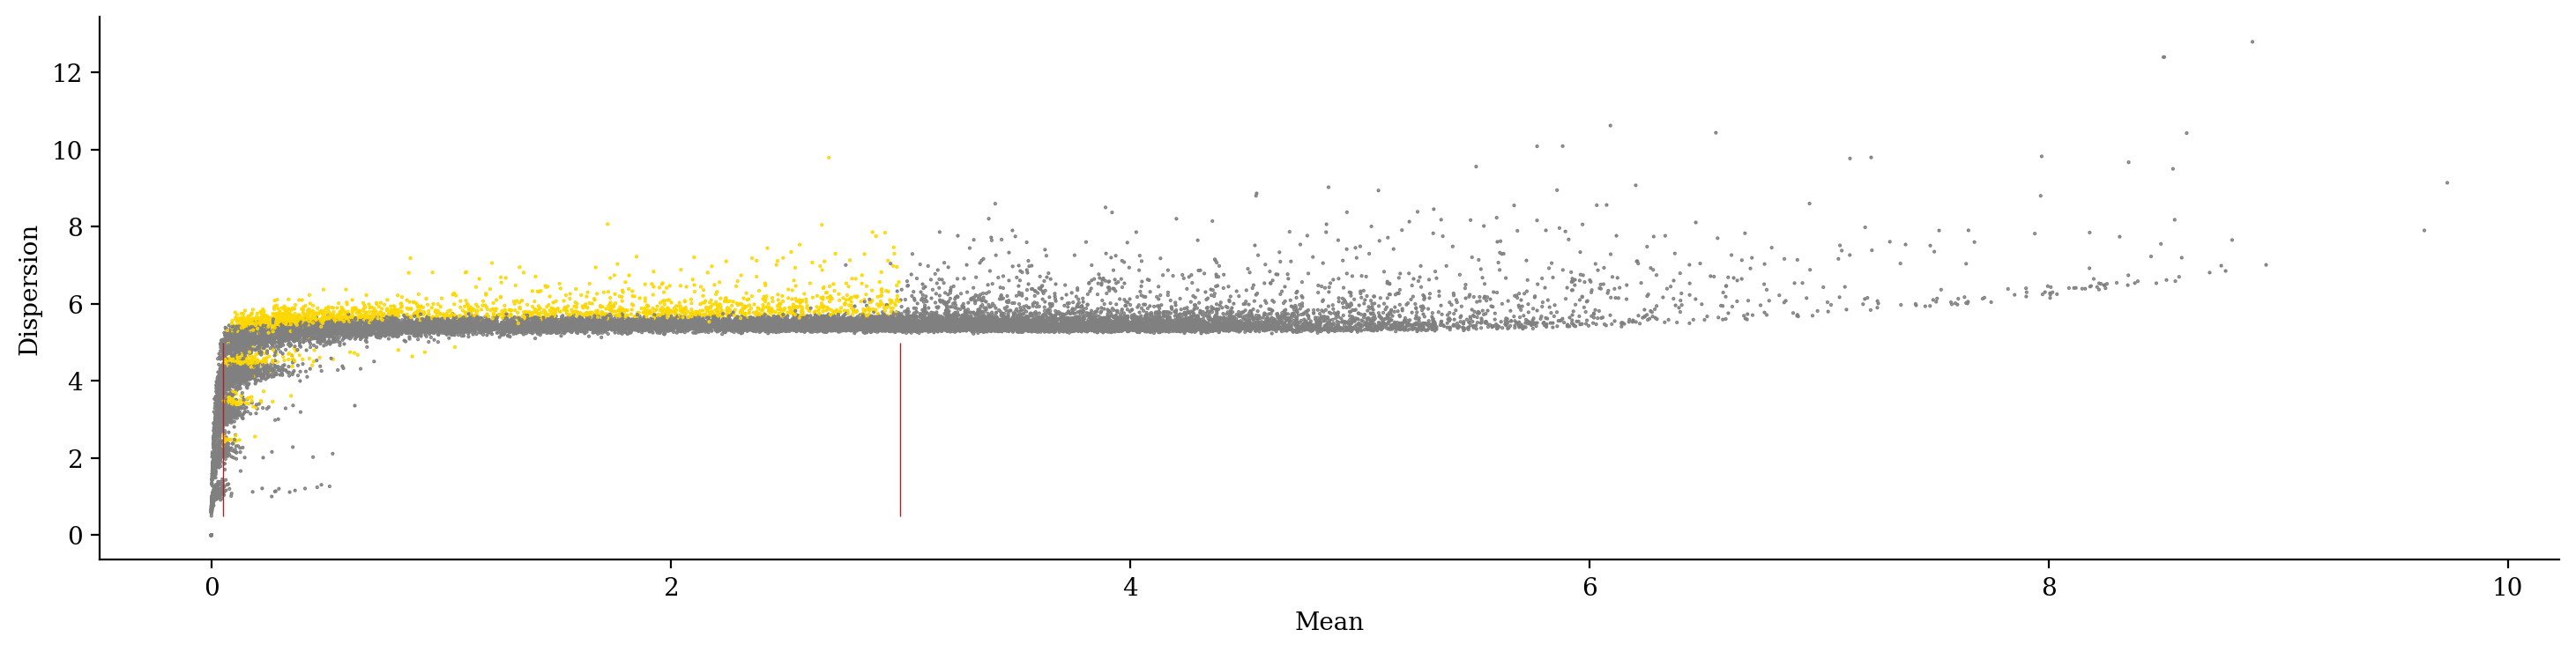

In [218]:
boolean_to_color = {True: "gold", False: "gray"}
chosen_highly_variables = adata_dataset_1_var_before.index.isin(final_hvg_selection)
hvg_colors = pd.Series(chosen_highly_variables).map(
    boolean_to_color
)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [219]:
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var.index.isin(final_hvg_selection)]
adata_dataset_1.shape

(21476, 2048)

In [220]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

adata_dataset_1.X = adata_dataset_1.layers["counts"].copy()
del adata_dataset_1.layers
del adata_dataset_1.uns
del adata_dataset_1.var
adata_dataset_1.obs = adata_dataset_1.obs[['sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates',
                       'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse']]
gc.collect()

print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

print()
display(adata_dataset_1)

Estimated adata memory usage: 19.26 MB
Estimated adata memory usage: 10.34 MB



AnnData object with n_obs × n_vars = 21476 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'

In [221]:
write_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/"
    "dataset_subset_age_1.h5ad"
)
adata_dataset_1.write_h5ad(write_path)

In [222]:
sc.pp.filter_cells(adata_dataset_1, min_genes=10, inplace=True)
display(adata_dataset_1.obs["age"].value_counts())
print()

sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)
print()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", ".*DataFrame is highly fragmented.*")
    calculate_de_genes(adata_dataset_1)
calc_de = copy.deepcopy(adata_dataset_1.uns[RANK_GENES_GROUPS_KEY])
display(adata_dataset_1)
print()
del adata_dataset_1
gc.collect();

adata_dataset_1 = ad.read_h5ad(write_path)
adata_dataset_1.uns[RANK_GENES_GROUPS_KEY] = calc_de
display(adata_dataset_1)
print()
adata_dataset_1.write_h5ad(write_path)
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")
del adata_dataset_1
gc.collect();

filtered out 4723 cells that have less than 10 genes expressed


11.0    5140
22.0    3849
18.0    3573
15.0    2717
20.0    1474
Name: age, dtype: int64


normalizing counts per cell
    finished (0:00:00)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


AnnData object with n_obs × n_vars = 16753 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes'
    uns: 'log1p', 'rank_genes_groups'

AnnData object with n_obs × n_vars = 21476 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'
    uns: 'rank_genes_groups'


Estimated adata memory usage: 10.91 MB


## Training data for `age_2` experiment

- Multiple batch from a single age

In [223]:
stats_colin = batch_stats[batch_stats["dataset"] == "Colin"].copy()
for i in ['sex', 'organ', 'age', 'library_platform', 'biological_unit', 'sample_status']:
    assert all([len(j) == 1 for j in stats_colin[i]])
    stats_colin[i] = [j[0] for j in stats_colin[i]]
stats_colin = stats_colin.sort_values(by=["sex", "age", "n_cells"], ascending=False)
stats_colin = stats_colin[(stats_colin["sex"] == "F") & (stats_colin["age"] != 10.0)]
colin_chosen_batches = list(stats_colin["batch_key"].unique())

In [224]:
stats_colin_chosen = stats_colin[stats_colin["batch_key"].isin(colin_chosen_batches)].copy()
stats_colin_chosen

dataset                                   batch_key sex   organ   age  \
44   Colin  donor_2_PCW20_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  20.0   
43   Colin  donor_1_PCW20_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  20.0   
35   Colin  donor_1_PCW13_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  13.0   
37   Colin  donor_3_PCW13_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  13.0   
31   Colin  donor_1_PCW12_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  12.0   
34   Colin  donor_4_PCW12_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  12.0   
33   Colin  donor_3_PCW12_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  12.0   

   library_platform biological_unit sample_status  n_library_platform  \
44             3GEX            Cell        Frozen                   1   
43             3GEX            Cell        Frozen                   1   
35             3GEX            Cell        Frozen                   1   
37             3GEX            Cell        Frozen                   1   
31             3GEX            Cell        Frozen                   1   
34             3GEX            Cell        Frozen                   1   
33             3GEX            Cell        Frozen                   1   

    n_biological_unit  ...  n_organ  n_age  n_celltypes  n_cells  n_genes  \
44                  1  ...        1      1           16    11162    20820   
43                  1  ...        1      1            9     3488    20820   
35                  1  ...        1      1           14     7289    20820   
37                  1  ...        1      1           14     5303    20820   
31                  1  ...        1      1           14     8117    20820   
34                  1  ...        1      1           14     2807    20820   
33                  1  ...        1      1           14     1339    20820   

    cells_per_celltypes         sum         mean           std  median  
44           697.625000  95312510.0  4577.930355  40472.422785   586.0  
43           387.555556   8221495.0   394.884486   6586.121189    18.0  
35           520.642857  60013121.0  2882.474592  26205.979552   296.0  
37           378.785714  47593950.0  2285.972622  25300.055451   246.0  
31           579.785714  66024248.0  3171.193468  30533.871868   318.0  
34           200.500000  27650677.0  1328.082469  11823.602564   152.5  
33            95.642857  14909862.0   716.131700   7212.829262    81.0  

[7 rows x 22 columns]

In [225]:
stats_colin_chosen.groupby('age').agg(Size=('age', 'size'), Sum=('n_cells', 'sum'))

Size    Sum
age              
12.0     3  12263
13.0     2  12592
20.0     2  14650

In [226]:
adata_dataset_1 = adata[adata.obs["concatenated_integration_covariates"].isin(colin_chosen_batches)]
batch_dataset = adata_dataset_1.obs["handle_anndata"].unique()[0]
var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var[var_column] != NA_CELL_TYPE_PLACEHOLDER].copy()
adata_dataset_1.shape

(39505, 20820)

In [227]:
min_cell_count = 10
batches_cell_type = list()
for batch_key in colin_chosen_batches:
    batch_adata_obs = adata_dataset_1.obs[adata_dataset_1.obs["concatenated_integration_covariates"] == batch_key]
    batch_cell_type_vc = batch_adata_obs["cell_type"].value_counts()
    batch_cell_type = set(batch_cell_type_vc[batch_cell_type_vc > min_cell_count].index)
    batches_cell_type.append(batch_cell_type)
chosen_cell_types = reduce(set.intersection, batches_cell_type)
adata_dataset_1 = adata_dataset_1[adata_dataset_1.obs["cell_type"].isin(chosen_cell_types), :].copy()
adata_dataset_1.shape, len(chosen_cell_types)

((18923, 20820), 2)

In [228]:
adata_dataset_1.obs.groupby("age").size()

age
12.0    7164
13.0    3797
20.0    7962
dtype: int64

In [229]:
adata_dataset_1.obs.groupby("cell_type").size()

cell_type
Fibroblasts     8149
Keratocytes    10774
dtype: int64

In [230]:
# remove cell-cycle, bcr, tcr. Also, scanpy filter genes
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var["highly_variable_omitted_reason"] == "NA"].copy()
del adata_dataset_1.var
gc.collect()
adata_dataset_1.shape

(18923, 20296)

In [231]:
adata_dataset_1.layers["counts"] = adata_dataset_1.X.copy()
sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)

normalizing counts per cell
    finished (0:00:00)


In [232]:
# Calculate dispersion and mean with scanpy function to determine max and min means.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    highly_variable_genes(
        adata=adata_dataset_1, 
        layer=None, 
        batch_key="concatenated_integration_covariates", 
        subset=False, 
        inplace=True
    )
    adata_dataset_1.var.drop(columns=["highly_variable"], inplace=True)
adata_dataset_1_var_before = adata_dataset_1.var.copy()
gc.collect();

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [233]:
hvg_dict = dict(
    hvg_number=2**11, 
    min_mean=0.05, 
    max_mean=3
)

Filter-in:  11936
Filter-out: 8360


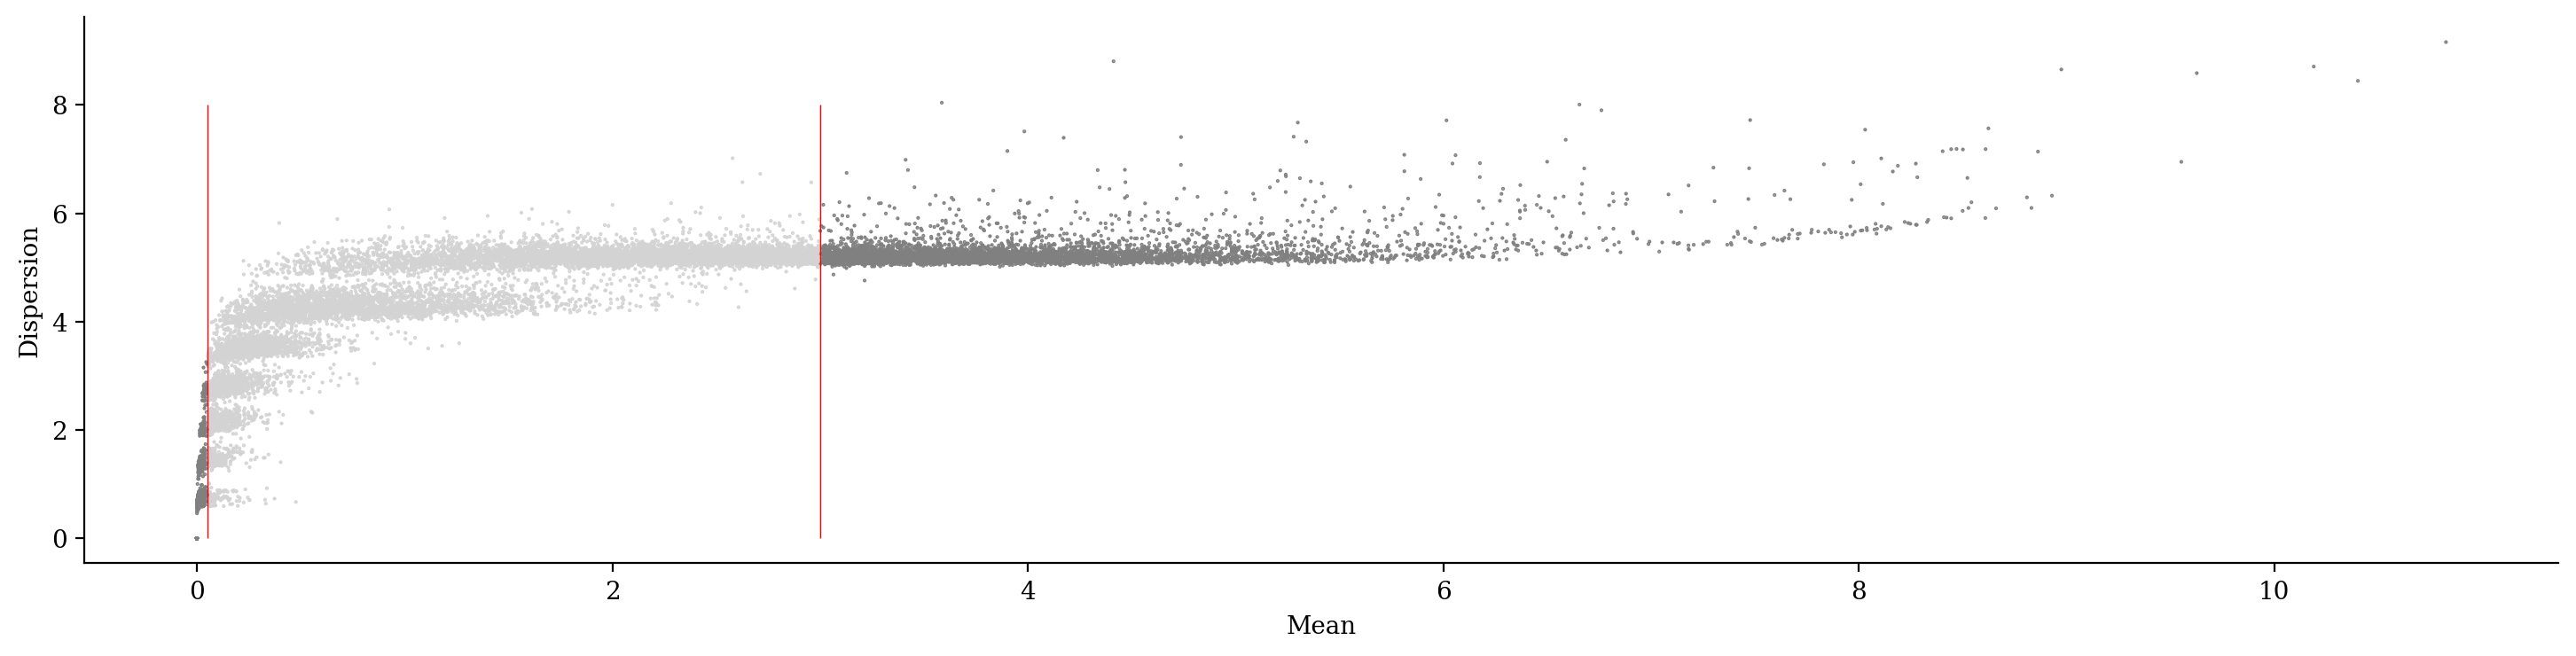

In [234]:
# Visualize the effect of thresholds.
filter_in = np.logical_and.reduce(
    (adata_dataset_1_var_before["means"] > (hvg_dict["min_mean"] if hvg_dict["min_mean"] is not None else -np.inf), 
     adata_dataset_1_var_before["means"] < (hvg_dict["max_mean"] if hvg_dict["max_mean"] is not None else np.inf)
    )
)
print(f"Filter-in:  {np.sum(filter_in)}")
print(f"Filter-out: {len(adata_dataset_1_var_before) - np.sum(filter_in)}")

boolean_to_color = {True: "lightgray", False: "gray"}
hvg_colors = pd.Series(filter_in).map(boolean_to_color)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [235]:
_, final_hvg_selection, _ = select_hvgs(
    adata_var=adata_dataset_1.var.copy(),
    top_gene_number=hvg_dict["hvg_number"],
    min_mean=hvg_dict["min_mean"],
    max_mean=hvg_dict["max_mean"],
)

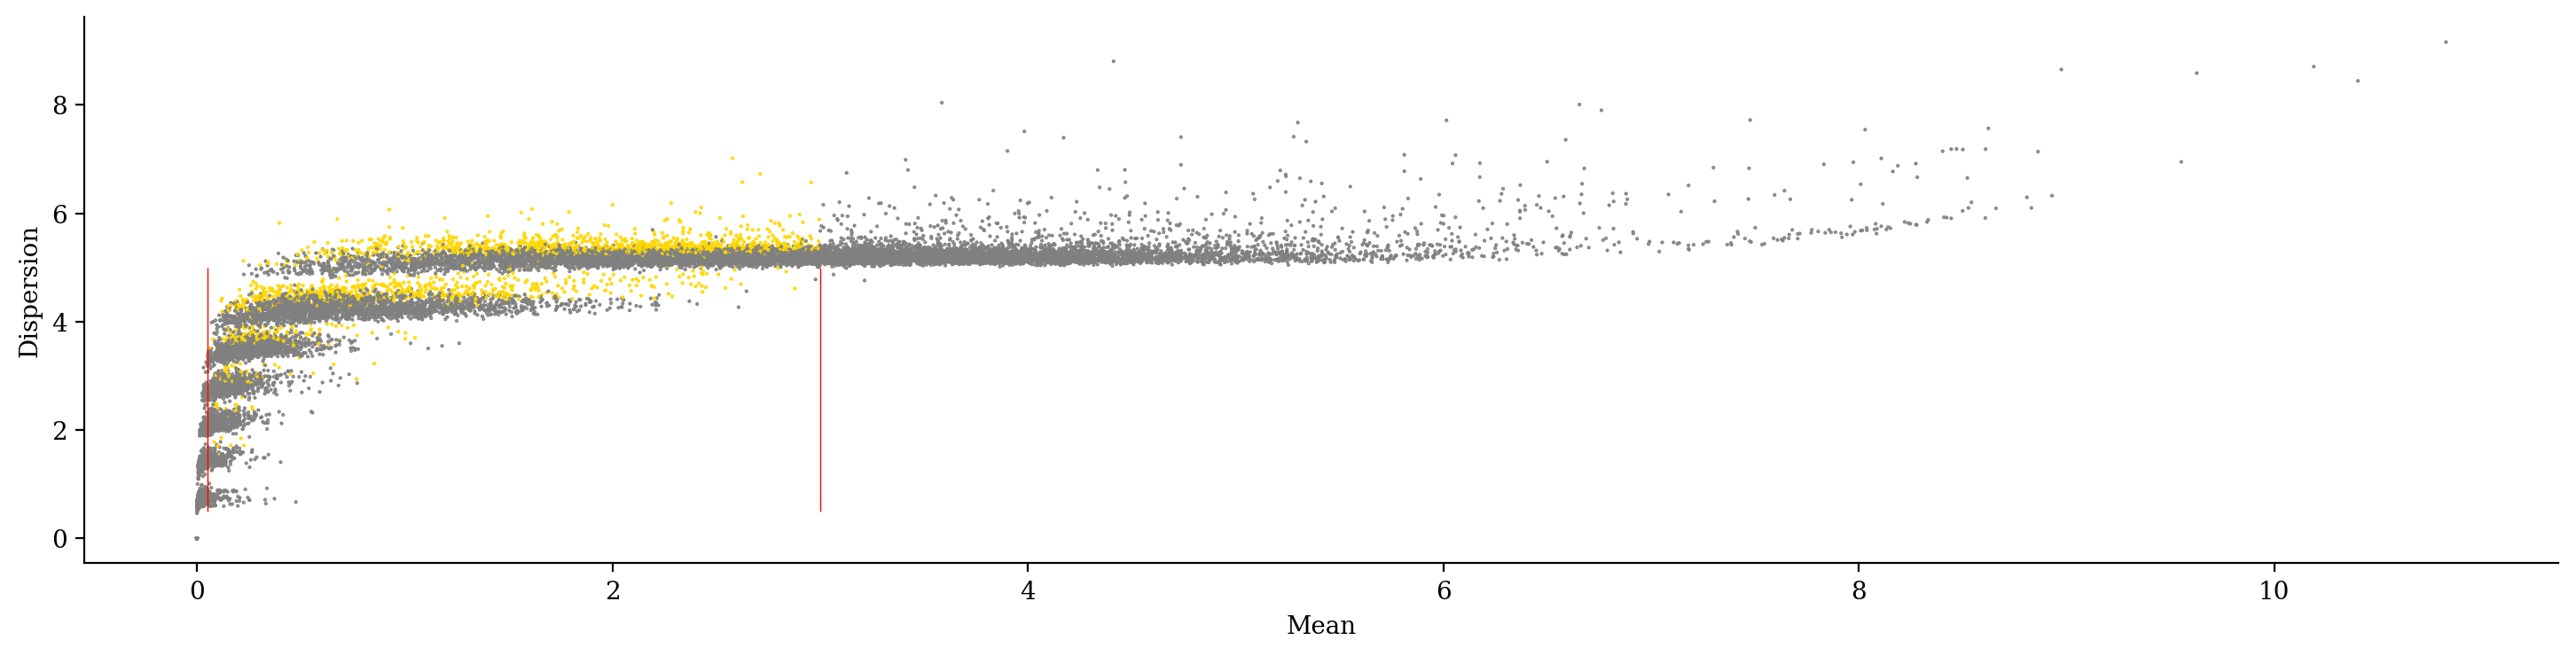

In [236]:
boolean_to_color = {True: "gold", False: "gray"}
chosen_highly_variables = adata_dataset_1_var_before.index.isin(final_hvg_selection)
hvg_colors = pd.Series(chosen_highly_variables).map(
    boolean_to_color
)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [237]:
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var.index.isin(final_hvg_selection)]
adata_dataset_1.shape

(18923, 2048)

In [238]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

adata_dataset_1.X = adata_dataset_1.layers["counts"].copy()
del adata_dataset_1.layers
del adata_dataset_1.uns
del adata_dataset_1.var
adata_dataset_1.obs = adata_dataset_1.obs[['sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates',
                       'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse']]
gc.collect()

print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

print()
display(adata_dataset_1)

Estimated adata memory usage: 37.43 MB
Estimated adata memory usage: 19.27 MB



AnnData object with n_obs × n_vars = 18923 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'

In [239]:
write_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/"
    "dataset_subset_age_2.h5ad"
)
adata_dataset_1.write_h5ad(write_path)

In [240]:
sc.pp.filter_cells(adata_dataset_1, min_genes=10, inplace=True)
display(adata_dataset_1.obs["age"].value_counts())
print()

sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)
print()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", ".*DataFrame is highly fragmented.*")
    calculate_de_genes(adata_dataset_1)
calc_de = copy.deepcopy(adata_dataset_1.uns[RANK_GENES_GROUPS_KEY])
display(adata_dataset_1)
print()
del adata_dataset_1
gc.collect();

adata_dataset_1 = ad.read_h5ad(write_path)
adata_dataset_1.uns[RANK_GENES_GROUPS_KEY] = calc_de
display(adata_dataset_1)
print()
adata_dataset_1.write_h5ad(write_path)
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")
del adata_dataset_1
gc.collect();

filtered out 589 cells that have less than 10 genes expressed


20.0    7378
12.0    7161
13.0    3795
Name: age, dtype: int64


normalizing counts per cell
    finished (0:00:00)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


AnnData object with n_obs × n_vars = 18334 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes'
    uns: 'log1p', 'rank_genes_groups'

AnnData object with n_obs × n_vars = 18923 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'
    uns: 'rank_genes_groups'


Estimated adata memory usage: 19.83 MB


## Training data for `age_3` experiment

- smallest dataset

In [241]:
stats_yu = batch_stats[batch_stats["dataset"] == "Yu"].copy()
for i in ['sex', 'organ', 'age', 'library_platform', 'biological_unit', 'sample_status']:
    assert all([len(j) == 1 for j in stats_yu[i]])
    stats_yu[i] = [j[0] for j in stats_yu[i]]
stats_yu = stats_yu.sort_values(by=["sex", "age", "n_cells"], ascending=False)
# stats_yu = stats_yu[(stats_yu["sex"] == "F") & (stats_yu["age"] != 10.0)]
yu_chosen_batches = list(stats_yu["batch_key"].unique())

In [242]:
stats_yu_chosen = stats_yu[stats_yu["batch_key"].isin(yu_chosen_batches)].copy()
stats_yu_chosen

dataset                     batch_key sex    organ   age library_platform  \
185      Yu  S18_Yu_et_al_Cell_Fresh_3GEX   M  Stomach  17.0             3GEX   
184      Yu  S17_Yu_et_al_Cell_Fresh_3GEX   M  Stomach  17.0             3GEX   
187      Yu  S21_Yu_et_al_Cell_Fresh_3GEX   M  Stomach  14.0             3GEX   
186      Yu  S20_Yu_et_al_Cell_Fresh_3GEX   M  Stomach  14.0             3GEX   
188      Yu  S32_Yu_et_al_Cell_Fresh_3GEX   M  Stomach   7.0             3GEX   

    biological_unit sample_status  n_library_platform  n_biological_unit  ...  \
185            Cell         Fresh                   1                  1  ...   
184            Cell         Fresh                   1                  1  ...   
187            Cell         Fresh                   1                  1  ...   
186            Cell         Fresh                   1                  1  ...   
188            Cell         Fresh                   1                  1  ...   

     n_organ  n_age  n_celltypes  n_cells  n_genes  cells_per_celltypes  \
185        1      1            6     1516    34886           252.666667   
184        1      1            6     1160    34886           193.333333   
187        1      1            6     2639    34886           439.833333   
186        1      1            6     2156    34886           359.333333   
188        1      1            6     4515    34886           752.500000   

            sum        mean          std  median  
185   8914176.0  255.523018  2691.622190     3.0  
184  11478546.0  329.030155  3243.825621     4.0  
187  16564397.0  474.815026  5184.248117     6.0  
186  17232688.0  493.971450  5151.934564     5.0  
188  27947392.0  801.106232  8349.613610     9.0  

[5 rows x 22 columns]

In [243]:
stats_yu_chosen.groupby('age').agg(Size=('age', 'size'), Sum=('n_cells', 'sum'))

Size   Sum
age             
7.0      1  4515
14.0     2  4795
17.0     2  2676

In [244]:
adata_dataset_1 = adata[adata.obs["concatenated_integration_covariates"].isin(yu_chosen_batches)]
batch_dataset = adata_dataset_1.obs["handle_anndata"].unique()[0]
var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var[var_column] != NA_CELL_TYPE_PLACEHOLDER].copy()
adata_dataset_1.shape

(11986, 34886)

In [245]:
min_cell_count = 10
batches_cell_type = list()
for batch_key in yu_chosen_batches:
    batch_adata_obs = adata_dataset_1.obs[adata_dataset_1.obs["concatenated_integration_covariates"] == batch_key]
    batch_cell_type_vc = batch_adata_obs["cell_type"].value_counts()
    batch_cell_type = set(batch_cell_type_vc[batch_cell_type_vc > min_cell_count].index)
    batches_cell_type.append(batch_cell_type)
chosen_cell_types = reduce(set.intersection, batches_cell_type)
adata_dataset_1 = adata_dataset_1[adata_dataset_1.obs["cell_type"].isin(chosen_cell_types), :].copy()
adata_dataset_1.shape, len(chosen_cell_types)

((11828, 34886), 5)

In [246]:
adata_dataset_1.obs.groupby("age").size()

age
7.0     4505
14.0    4710
17.0    2613
dtype: int64

In [247]:
adata_dataset_1.obs.groupby("cell_type").size()

cell_type
Gastrointestinal epithelial cells          1101
Proliferating stomach mesenchymal cells    1115
Stomach PNS glia                            474
Stomach PNS neuron                          663
Stomach mesenchymal cells                  8475
dtype: int64

In [248]:
# remove cell-cycle, bcr, tcr. Also, scanpy filter genes
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var["highly_variable_omitted_reason"] == "NA"].copy()
del adata_dataset_1.var
gc.collect()
adata_dataset_1.shape

(11828, 33164)

In [249]:
adata_dataset_1.layers["counts"] = adata_dataset_1.X.copy()
sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)

normalizing counts per cell
    finished (0:00:00)


In [250]:
# Calculate dispersion and mean with scanpy function to determine max and min means.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    highly_variable_genes(
        adata=adata_dataset_1, 
        layer=None, 
        batch_key="concatenated_integration_covariates", 
        subset=False, 
        inplace=True
    )
    adata_dataset_1.var.drop(columns=["highly_variable"], inplace=True)
adata_dataset_1_var_before = adata_dataset_1.var.copy()
gc.collect();

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [251]:
hvg_dict = dict(
    hvg_number=2**11, 
    min_mean=0.05, 
    max_mean=3
)

Filter-in:  15294
Filter-out: 17870


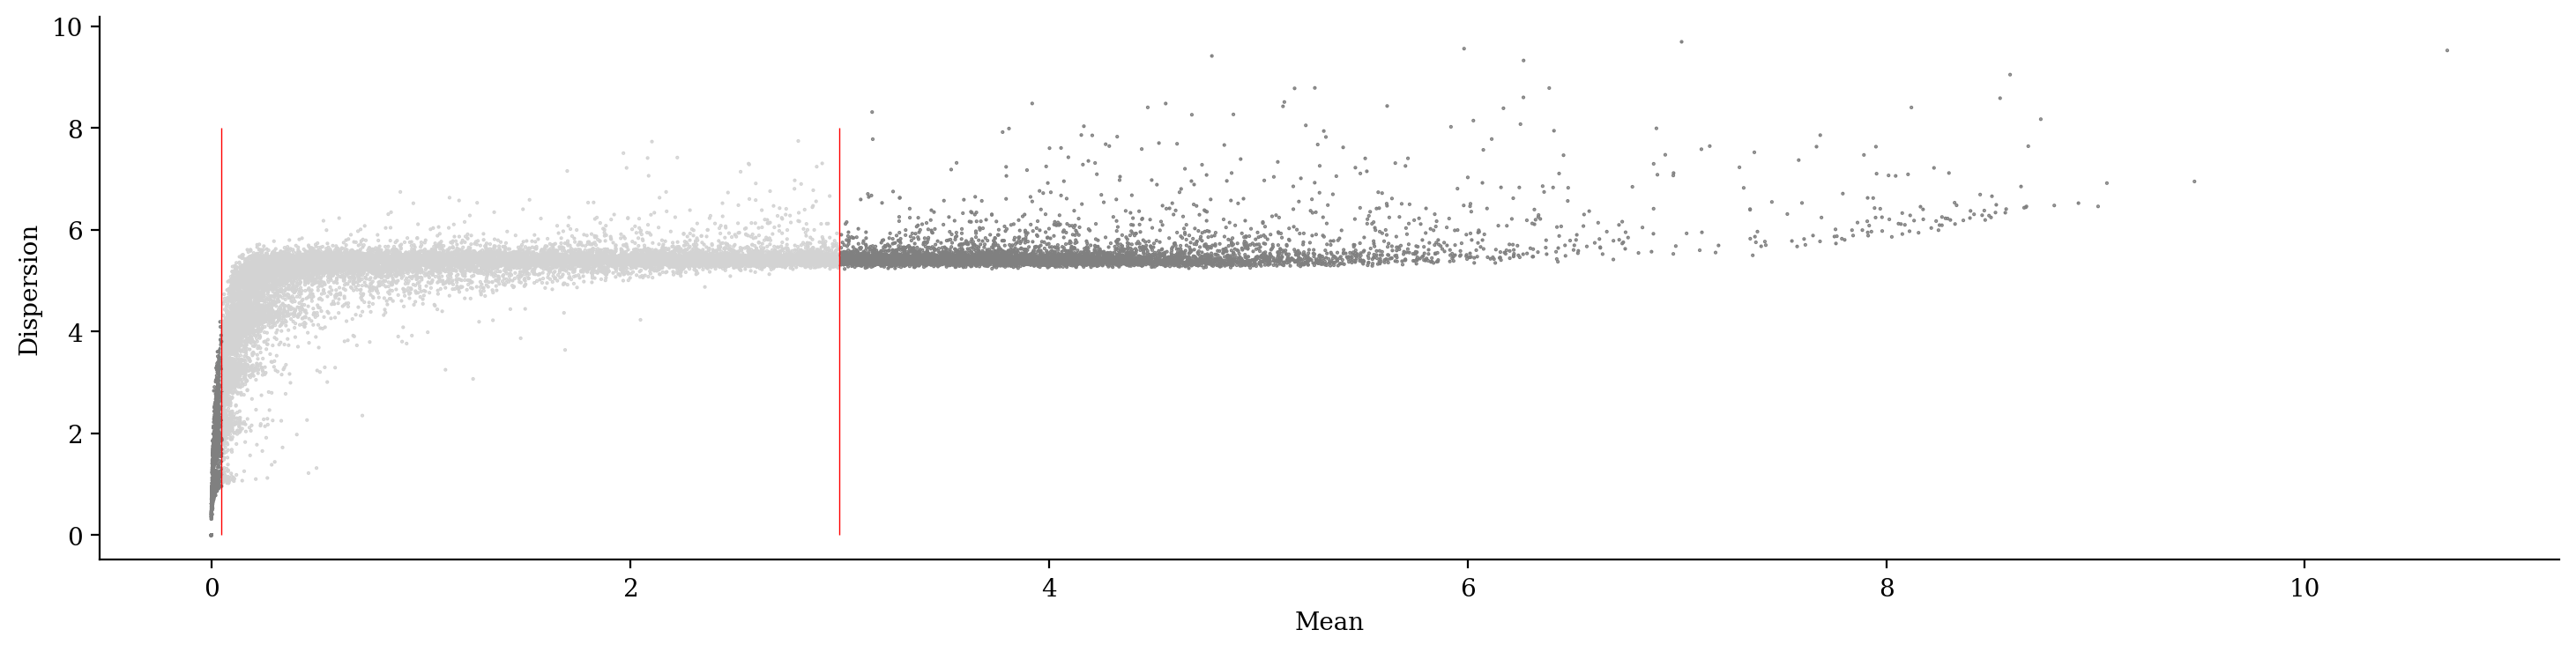

In [252]:
# Visualize the effect of thresholds.
filter_in = np.logical_and.reduce(
    (adata_dataset_1_var_before["means"] > (hvg_dict["min_mean"] if hvg_dict["min_mean"] is not None else -np.inf), 
     adata_dataset_1_var_before["means"] < (hvg_dict["max_mean"] if hvg_dict["max_mean"] is not None else np.inf)
    )
)
print(f"Filter-in:  {np.sum(filter_in)}")
print(f"Filter-out: {len(adata_dataset_1_var_before) - np.sum(filter_in)}")

boolean_to_color = {True: "lightgray", False: "gray"}
hvg_colors = pd.Series(filter_in).map(boolean_to_color)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [253]:
_, final_hvg_selection, _ = select_hvgs(
    adata_var=adata_dataset_1.var.copy(),
    top_gene_number=hvg_dict["hvg_number"],
    min_mean=hvg_dict["min_mean"],
    max_mean=hvg_dict["max_mean"],
)

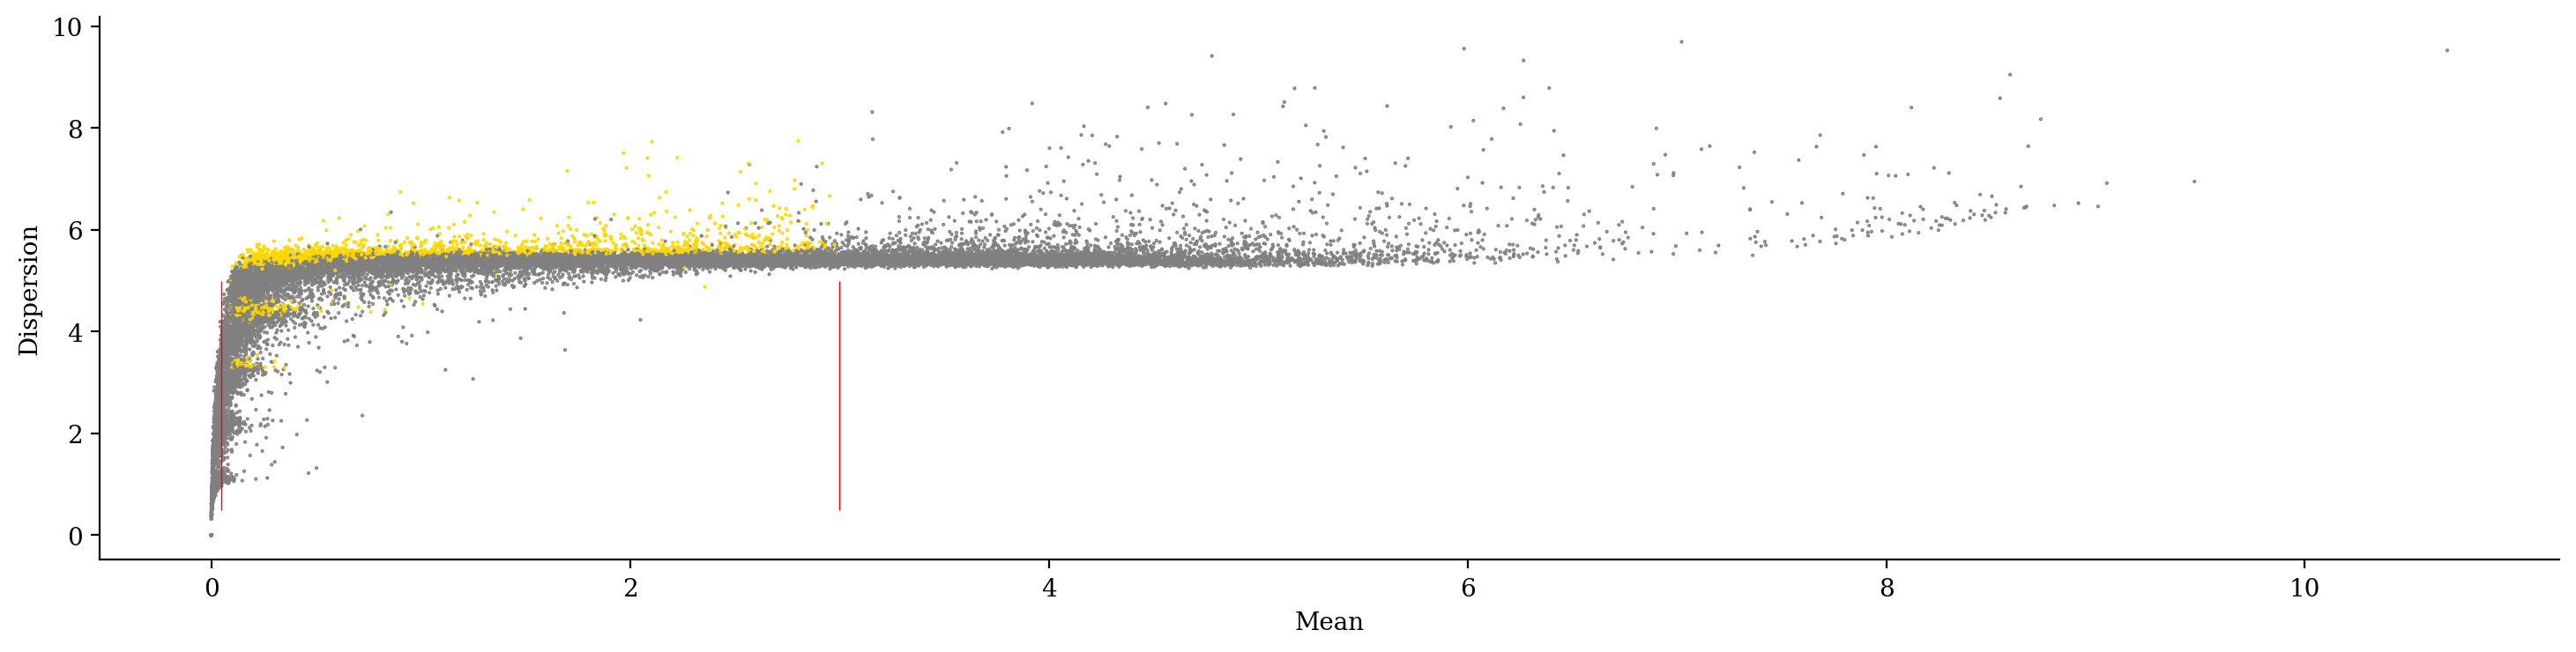

In [254]:
boolean_to_color = {True: "gold", False: "gray"}
chosen_highly_variables = adata_dataset_1_var_before.index.isin(final_hvg_selection)
hvg_colors = pd.Series(chosen_highly_variables).map(
    boolean_to_color
)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [255]:
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var.index.isin(final_hvg_selection)]
adata_dataset_1.shape

(11828, 2048)

In [256]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

adata_dataset_1.X = adata_dataset_1.layers["counts"].copy()
del adata_dataset_1.layers
del adata_dataset_1.uns
del adata_dataset_1.var
adata_dataset_1.obs = adata_dataset_1.obs[['sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates',
                       'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse']]
gc.collect()

print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

print()
display(adata_dataset_1)

Estimated adata memory usage: 9.56 MB
Estimated adata memory usage: 5.13 MB



AnnData object with n_obs × n_vars = 11828 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'

In [257]:
write_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/"
    "dataset_subset_age_3.h5ad"
)
adata_dataset_1.write_h5ad(write_path)

In [258]:
sc.pp.filter_cells(adata_dataset_1, min_genes=10, inplace=True)
display(adata_dataset_1.obs["age"].value_counts())
print()

sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)
print()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", ".*DataFrame is highly fragmented.*")
    calculate_de_genes(adata_dataset_1)
calc_de = copy.deepcopy(adata_dataset_1.uns[RANK_GENES_GROUPS_KEY])
display(adata_dataset_1)
print()
del adata_dataset_1
gc.collect();

adata_dataset_1 = ad.read_h5ad(write_path)
adata_dataset_1.uns[RANK_GENES_GROUPS_KEY] = calc_de
display(adata_dataset_1)
print()
adata_dataset_1.write_h5ad(write_path)
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")
del adata_dataset_1
gc.collect();

filtered out 374 cells that have less than 10 genes expressed


14.0    4551
7.0     4347
17.0    2556
Name: age, dtype: int64


normalizing counts per cell
    finished (0:00:00)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


AnnData object with n_obs × n_vars = 11454 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes'
    uns: 'log1p', 'rank_genes_groups'

AnnData object with n_obs × n_vars = 11828 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'
    uns: 'rank_genes_groups'


Estimated adata memory usage: 5.45 MB


## Training data for `age` and `sex` experiment

In [259]:
stats_colin = batch_stats[batch_stats["dataset"] == "Colin"].copy()
for i in ['sex', 'organ', 'age', 'library_platform', 'biological_unit', 'sample_status']:
    assert all([len(j) == 1 for j in stats_colin[i]])
    stats_colin[i] = [j[0] for j in stats_colin[i]]
stats_colin = stats_colin.sort_values(by=["sex", "age", "n_cells"], ascending=False).drop_duplicates(["sex", "age"])
stats_colin = stats_colin[~stats_colin["age"].isin([10.0, 16.0, 17.0])]
colin_chosen_batches = list(stats_colin["batch_key"])
stats_colin_chosen = stats_colin[stats_colin["batch_key"].isin(colin_chosen_batches)].copy()
stats_colin_chosen

dataset                                   batch_key sex   organ   age  \
45   Colin  donor_3_PCW20_Colin_et_al_Cell_Frozen_3GEX   M  Cornea  20.0   
38   Colin  donor_4_PCW13_Colin_et_al_Cell_Frozen_3GEX   M  Cornea  13.0   
32   Colin  donor_2_PCW12_Colin_et_al_Cell_Frozen_3GEX   M  Cornea  12.0   
44   Colin  donor_2_PCW20_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  20.0   
35   Colin  donor_1_PCW13_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  13.0   
31   Colin  donor_1_PCW12_Colin_et_al_Cell_Frozen_3GEX   F  Cornea  12.0   

   library_platform biological_unit sample_status  n_library_platform  \
45             3GEX            Cell        Frozen                   1   
38             3GEX            Cell        Frozen                   1   
32             3GEX            Cell        Frozen                   1   
44             3GEX            Cell        Frozen                   1   
35             3GEX            Cell        Frozen                   1   
31             3GEX            Cell        Frozen                   1   

    n_biological_unit  ...  n_organ  n_age  n_celltypes  n_cells  n_genes  \
45                  1  ...        1      1           16     7553    20820   
38                  1  ...        1      1           14     5525    20820   
32                  1  ...        1      1           14     8353    20820   
44                  1  ...        1      1           16    11162    20820   
35                  1  ...        1      1           14     7289    20820   
31                  1  ...        1      1           14     8117    20820   

    cells_per_celltypes         sum         mean           std  median  
45           472.062500  85938985.0  4127.713016  33857.654259   593.0  
38           394.642857  79464637.0  3816.745293  33878.817705   471.5  
32           596.642857  73586486.0  3534.413353  30354.904459   350.0  
44           697.625000  95312510.0  4577.930355  40472.422785   586.0  
35           520.642857  60013121.0  2882.474592  26205.979552   296.0  
31           579.785714  66024248.0  3171.193468  30533.871868   318.0  

[6 rows x 22 columns]

In [260]:
stats_colin_chosen.groupby('age').agg(Size=('age', 'size'), Sum=('n_cells', 'sum')), stats_colin_chosen.groupby('sex').agg(Size=('sex', 'size'), Sum=('n_cells', 'sum')), 

(      Size    Sum
 age              
 12.0     2  16470
 13.0     2  12814
 20.0     2  18715,
      Size    Sum
 sex             
 F       3  26568
 M       3  21431)

In [261]:
adata_dataset_1 = adata[adata.obs["concatenated_integration_covariates"].isin(colin_chosen_batches)]
batch_dataset = adata_dataset_1.obs["handle_anndata"].unique()[0]
var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var[var_column] != NA_CELL_TYPE_PLACEHOLDER].copy()
adata_dataset_1.shape

(47999, 20820)

In [262]:
min_cell_count = 100
batches_cell_type = list()
for batch_key in colin_chosen_batches:
    batch_adata_obs = adata_dataset_1.obs[adata_dataset_1.obs["concatenated_integration_covariates"] == batch_key]
    batch_cell_type_vc = batch_adata_obs["cell_type"].value_counts()
    batch_cell_type = set(batch_cell_type_vc[batch_cell_type_vc > min_cell_count].index)
    batches_cell_type.append(batch_cell_type)
chosen_cell_types = reduce(set.intersection, batches_cell_type)
adata_dataset_1 = adata_dataset_1[adata_dataset_1.obs["cell_type"].isin(chosen_cell_types), :].copy()
adata_dataset_1.shape, len(chosen_cell_types)

((27159, 20820), 4)

In [263]:
adata_dataset_1.obs.groupby(["age", "sex"]).size()

age   sex
12.0  F      5577
      M      5910
13.0  F      2920
      M      2610
20.0  F      6777
      M      3365
dtype: int64

In [264]:
# remove cell-cycle, bcr, tcr. Also, scanpy filter genes
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var["highly_variable_omitted_reason"] == "NA"].copy()
del adata_dataset_1.var
gc.collect()
adata_dataset_1.shape

(27159, 20296)

In [265]:
adata_dataset_1.layers["counts"] = adata_dataset_1.X.copy()
sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)

normalizing counts per cell
    finished (0:00:00)


In [266]:
# Calculate dispersion and mean with scanpy function to determine max and min means.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    highly_variable_genes(
        adata=adata_dataset_1, 
        layer=None, 
        batch_key="concatenated_integration_covariates", 
        subset=False, 
        inplace=True
    )
    adata_dataset_1.var.drop(columns=["highly_variable"], inplace=True)
adata_dataset_1_var_before = adata_dataset_1.var.copy()
gc.collect();

extracting highly variable genes
    finished (0:00:10)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [267]:
hvg_dict = dict(
    hvg_number=2**11, 
    min_mean=0.05, 
    max_mean=3
)

Filter-in:  12781
Filter-out: 7515


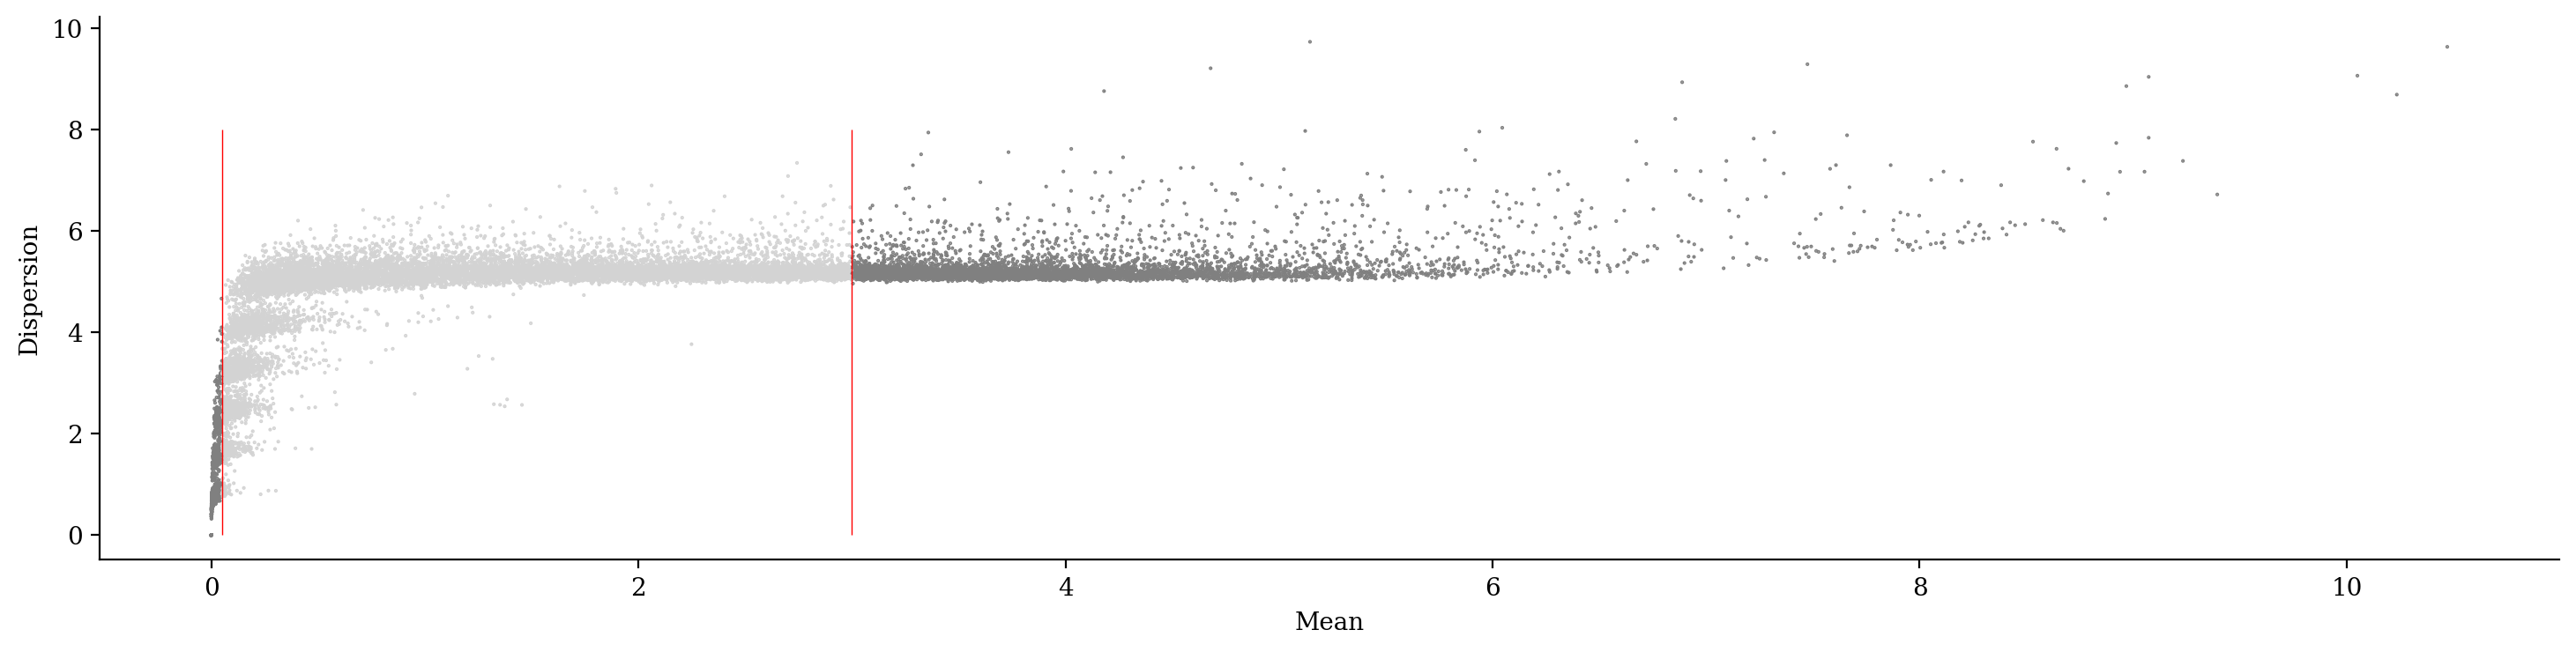

In [268]:
# Visualize the effect of thresholds.
filter_in = np.logical_and.reduce(
    (adata_dataset_1_var_before["means"] > (hvg_dict["min_mean"] if hvg_dict["min_mean"] is not None else -np.inf), 
     adata_dataset_1_var_before["means"] < (hvg_dict["max_mean"] if hvg_dict["max_mean"] is not None else np.inf)
    )
)
print(f"Filter-in:  {np.sum(filter_in)}")
print(f"Filter-out: {len(adata_dataset_1_var_before) - np.sum(filter_in)}")

boolean_to_color = {True: "lightgray", False: "gray"}
hvg_colors = pd.Series(filter_in).map(boolean_to_color)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0, ymax=8, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [269]:
_, final_hvg_selection, _ = select_hvgs(
    adata_var=adata_dataset_1.var.copy(),
    top_gene_number=hvg_dict["hvg_number"],
    min_mean=hvg_dict["min_mean"],
    max_mean=hvg_dict["max_mean"],
)

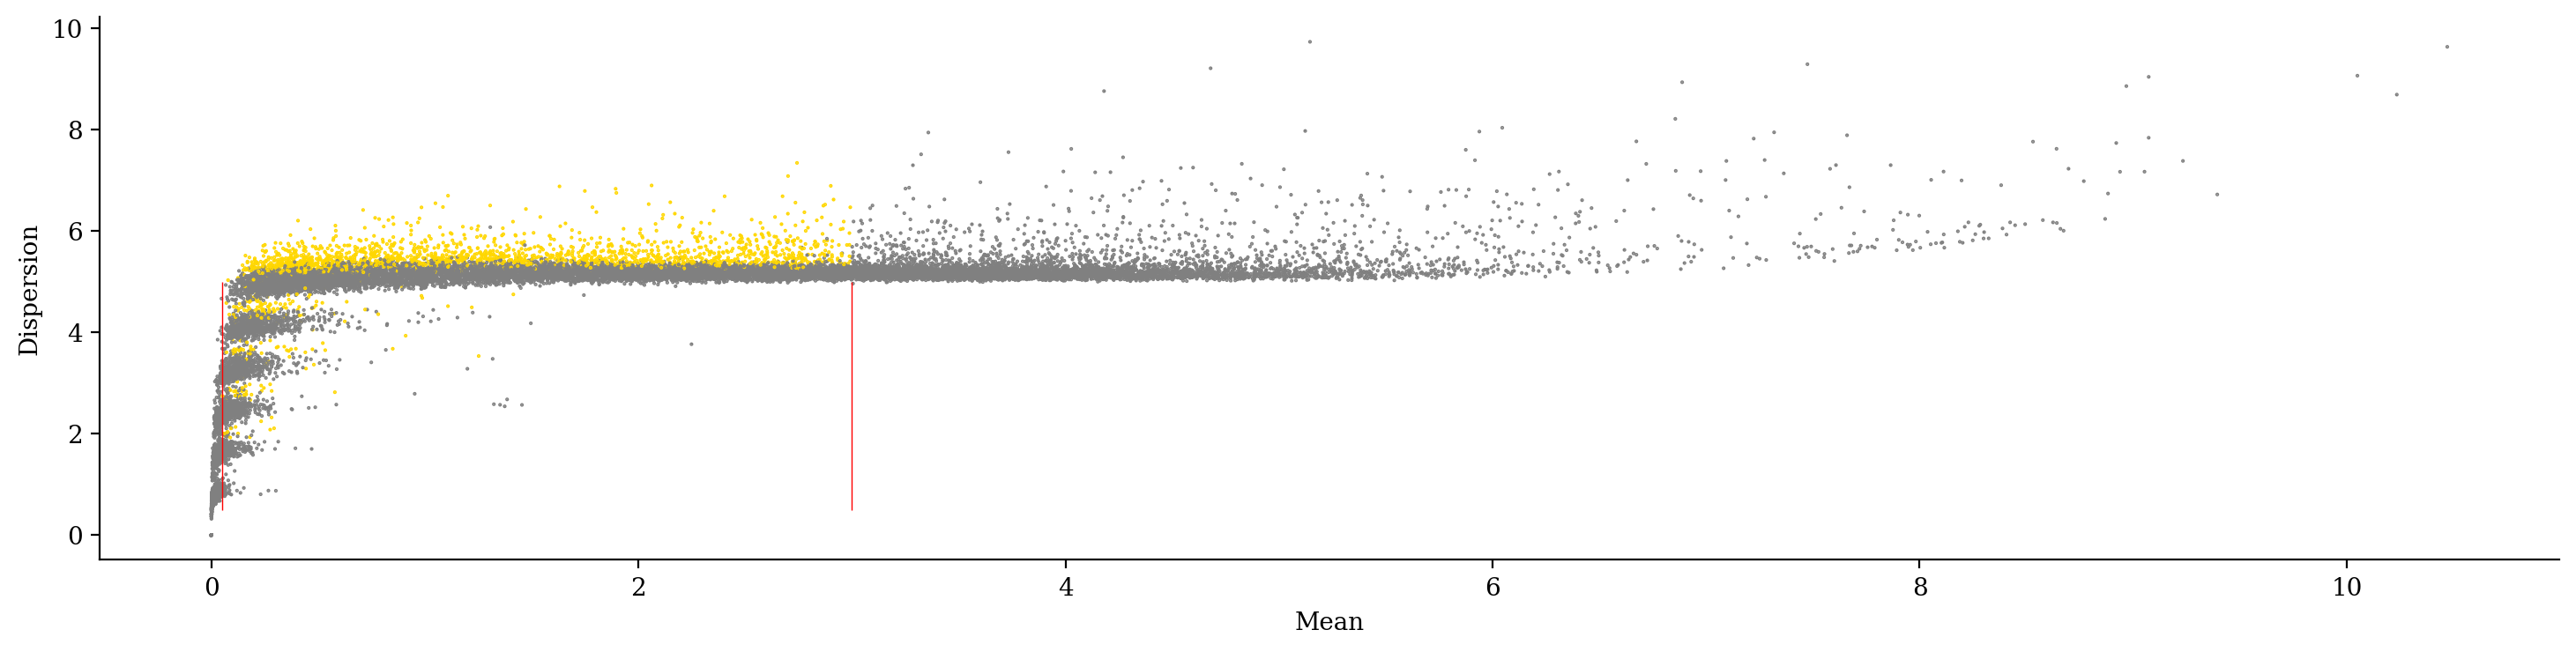

In [270]:
boolean_to_color = {True: "gold", False: "gray"}
chosen_highly_variables = adata_dataset_1_var_before.index.isin(final_hvg_selection)
hvg_colors = pd.Series(chosen_highly_variables).map(
    boolean_to_color
)  # 'convert' the boolean

plt.figure(figsize=(18, 4))
plt.scatter(
    adata_dataset_1_var_before["means"], adata_dataset_1_var_before["dispersions"], s=0.25, color=hvg_colors
)
if hvg_dict["min_mean"] is not None:
    plt.vlines(x=hvg_dict["min_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
if hvg_dict["max_mean"] is not None:
    plt.vlines(x=hvg_dict["max_mean"], ymin=0.5, ymax=5, color="red", linewidth=0.5)
sns.despine()
plt.xlabel("Mean")
plt.ylabel("Dispersion")
plt.show()

In [271]:
adata_dataset_1 = adata_dataset_1[:, adata_dataset_1.var.index.isin(final_hvg_selection)]
adata_dataset_1.shape

(27159, 2048)

In [272]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

adata_dataset_1.X = adata_dataset_1.layers["counts"].copy()
del adata_dataset_1.layers
del adata_dataset_1.uns
del adata_dataset_1.var
adata_dataset_1.obs = adata_dataset_1.obs[['sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates',
                       'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse']]
gc.collect()

print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")

print()
display(adata_dataset_1)

Estimated adata memory usage: 42.38 MB
Estimated adata memory usage: 21.82 MB



AnnData object with n_obs × n_vars = 27159 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'

In [273]:
write_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/"
    "dataset_subset_age_sex_1.h5ad"
)
adata_dataset_1.write_h5ad(write_path)

In [276]:
sc.pp.filter_cells(adata_dataset_1, min_genes=10, inplace=True)
display(adata_dataset_1.obs.value_counts(["age", "sex"]))
print()

sc.pp.normalize_total(adata_dataset_1, target_sum=1e6)
sc.pp.log1p(adata_dataset_1)
print()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", ".*DataFrame is highly fragmented.*")
    calculate_de_genes(adata_dataset_1)
calc_de = copy.deepcopy(adata_dataset_1.uns[RANK_GENES_GROUPS_KEY])
display(adata_dataset_1)
print()
del adata_dataset_1
gc.collect();

adata_dataset_1 = ad.read_h5ad(write_path)
adata_dataset_1.uns[RANK_GENES_GROUPS_KEY] = calc_de
display(adata_dataset_1)
print()
adata_dataset_1.write_h5ad(write_path)
print(f"Estimated adata memory usage: {deep_memory_usage(adata_dataset_1)} MB")
del adata_dataset_1
gc.collect();

filtered out 126 cells that have less than 10 genes expressed


age   sex
20.0  F      6747
12.0  M      5900
      F      5542
20.0  M      3353
13.0  F      2883
      M      2608
dtype: int64


normalizing counts per cell
    finished (0:00:00)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


AnnData object with n_obs × n_vars = 27033 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes'
    uns: 'log1p', 'rank_genes_groups'

AnnData object with n_obs × n_vars = 27159 × 2048
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse'
    uns: 'rank_genes_groups'


Estimated adata memory usage: 22.89 MB


In [277]:
1

1

In [278]:
!ls -lh /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/

total 98M
-rw-r--r--. 1 kemal.inecik OG-ICB-User  13M Apr 15 09:55 dataset_subset_age_1.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User  20M Apr 15 09:57 dataset_subset_age_2.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 6.1M Apr 15 09:58 dataset_subset_age_3.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User  23M Apr 15 10:00 dataset_subset_age_sex_1.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User  13M Apr 15 09:53 dataset_subset_biological_unit_1.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 6.9M Apr 15 09:53 dataset_subset_sample_status_1.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User  11M Apr 15 09:53 dataset_subset_sex_1.h5ad
-rw-r--r--. 1 kemal.inecik OG-ICB-User 7.8M Apr 15 09:54 dataset_subset_sex_2.h5ad
